#Feature extraction from sequences

In [ ]:
import h5py
import torch
import numpy as np
import pandas as pd

# === Constants ===
SAMPLE_RATE = 100.0  # 1 / 0.01s = 100Hz
DURATION = 90.0      # 90 seconds
EXPECTED_SAMPLES = int(SAMPLE_RATE * DURATION)  # Should be 9000

# === ROCOF Calculation (Updated fs) ===
def compute_max_rocof(signal: torch.Tensor, sample_rate: float = SAMPLE_RATE) -> float:
    N = len(signal)
    fft_signal = torch.fft.fft(signal)
    analytic_fft = torch.cat([
        fft_signal[0:1],
        2 * fft_signal[1:N//2],
        fft_signal[N//2:N//2+1],
        torch.zeros(N - N//2 - 1, device=signal.device)
    ])
    analytic_signal = torch.fft.ifft(analytic_fft)
    phase = torch.angle(analytic_signal)
    instantaneous_freq = torch.diff(phase) * (sample_rate / (2 * torch.pi))
    rocof = torch.diff(instantaneous_freq) * sample_rate
    return torch.max(torch.abs(rocof)).item()

# === Time of Nadir (Updated fs) ===
def find_nadir_time(signal: torch.Tensor, sample_rate: float = SAMPLE_RATE) -> float:
    nadir_idx = torch.argmin(signal).item()
    return nadir_idx / sample_rate  # Time in seconds

# === Load Data ===
with h5py.File('simulink_dataset_different_disturbances_2_hydro_sources_probe_signal.mat', 'r') as f:
    all_data = f['all_data'][:]        # shape: (3, 9000, N) [Verify!]
    all_targets = f['all_targets'][:]  # shape: (2, N)

# # === Verify Signal Length ===
# if all_data.shape[1] != EXPECTED_SAMPLES:
#     print(f"⚠️ Warning: Expected {EXPECTED_SAMPLES} samples, got {all_data.shape[1]}. Adjust SAMPLE_RATE or DURATION.")

# === Transpose Data ===
X = torch.tensor(np.transpose(all_data, (2, 1, 0)), dtype=torch.float32)  # (N, 9000, 3)
Y = torch.tensor(all_targets.T, dtype=torch.float32)                      # (N, 2)

# === Feature Extraction (Now uses SAMPLE_RATE) ===
def extract_features(signal, sample_rate=SAMPLE_RATE):
    return {
        'mean': signal.mean().item(),
        'std': signal.std().item(),
        'max': signal.max().item(),
        'min': signal.min().item(),
        'ptp': (signal.max() - signal.min()).item(),
        'rms': torch.sqrt(torch.mean(signal**2)).item(),
        'max_rocof': compute_max_rocof(signal, sample_rate),
        'nadir_time': find_nadir_time(signal, sample_rate)
    }

# === RMS Ratio (Unchanged) ===
def compute_rms_ratio(signal, early_pct=0.3, late_pct=0.1):
    T = signal.shape[0]
    early_len = int(T * early_pct)
    late_len = int(T * late_pct)
    early_rms = torch.sqrt(torch.mean(signal[:early_len] ** 2)).item()
    late_rms = torch.sqrt(torch.mean(signal[-late_len:] ** 2)).item()
    return late_rms / (early_rms + 1e-8)

# === Process All Samples ===
rows = []
for i in range(X.shape[0]):
    feats = {}
    for j, name in enumerate(['f1', 'f2', 'ptie']):
        sig = X[i, :, j]
        sig_feats = extract_features(sig, SAMPLE_RATE)
        for stat, val in sig_feats.items():
            feats[f"{name}_{stat}"] = val
        feats[f"{name}_rms_ratio"] = compute_rms_ratio(sig)
    feats['H1'] = Y[i, 0].item()
    feats['H2'] = Y[i, 1].item()
    rows.append(feats)

# === Save CSV ===
df = pd.DataFrame(rows)
df.to_csv("simulink_features_hydro_power_sources.csv", index=False)
print(f"✅ Saved features for {SAMPLE_RATE}Hz sampling to 'simulink_features_hydro_power_sources.csv'")

✅ Saved features for 100.0Hz sampling to 'simulink_features_hydro_power_sources.csv'


In [ ]:
import h5py
import torch
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# === Load the dataset ===
with h5py.File('simulink_dataset_different_disturbances_2_hydro_sources_probe_signal.mat', 'r') as f:
    all_data = f['all_data'][:]        # shape: (3, 6001, N)
    all_targets = f['all_targets'][:]  # shape: (2, N)

In [ ]:
print(all_data.shape)
print(all_targets.shape)

(3, 9001, 1000)
(2, 1000)


In [ ]:
import matplotlib.pyplot as plt

def plot_sample(idx, X, Y, title_suffix=""):
    Δf1 = X[idx, :, 0].numpy()
    Δf2 = X[idx, :, 1].numpy()
    ΔPtie = X[idx, :, 2].numpy()
    H1, H2 = Y[idx, 0].item(), Y[idx, 1].item()

    plt.figure(figsize=(14, 4))
    plt.plot(Δf1, label="Δf1")
    plt.plot(Δf2, label="Δf2")
    plt.plot(ΔPtie, label="ΔPtie")
    plt.title(f"Sample #{idx} — H1: {H1:.2f}, H2: {H2:.2f} {title_suffix}")
    plt.xlabel("Time Step (0.01s)")
    plt.ylabel("Signal Value")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Convert and transpose
X_old = torch.tensor(np.transpose(all_data, (2, 1, 0)), dtype=torch.float32)  # (N, 6001, 3)
Y_old = torch.tensor(all_targets.T, dtype=torch.float32)                      # (N, 2)

print(X_old.shape)
print(Y_old.shape)

torch.Size([1000, 9001, 3])
torch.Size([1000, 2])


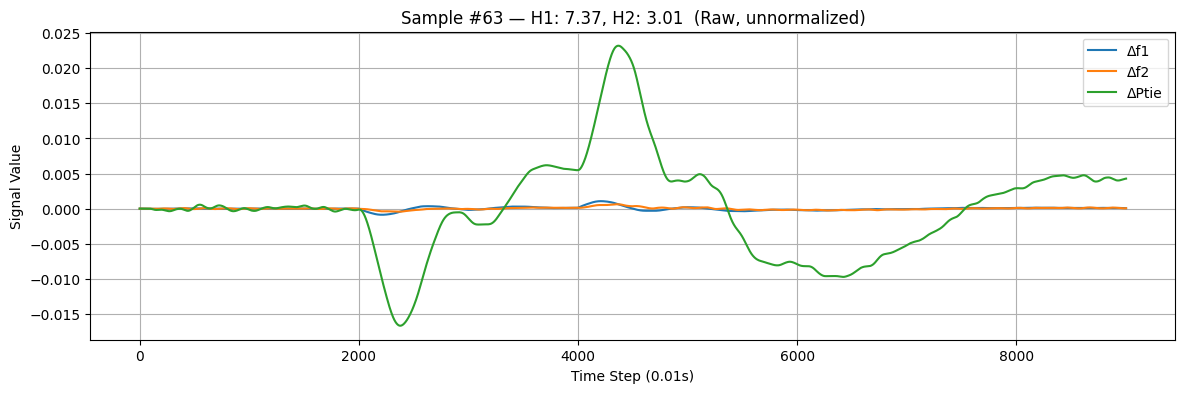

In [ ]:
plot_sample(idx=63, X=X_old, Y=Y_old, title_suffix=" (Raw, unnormalized)")

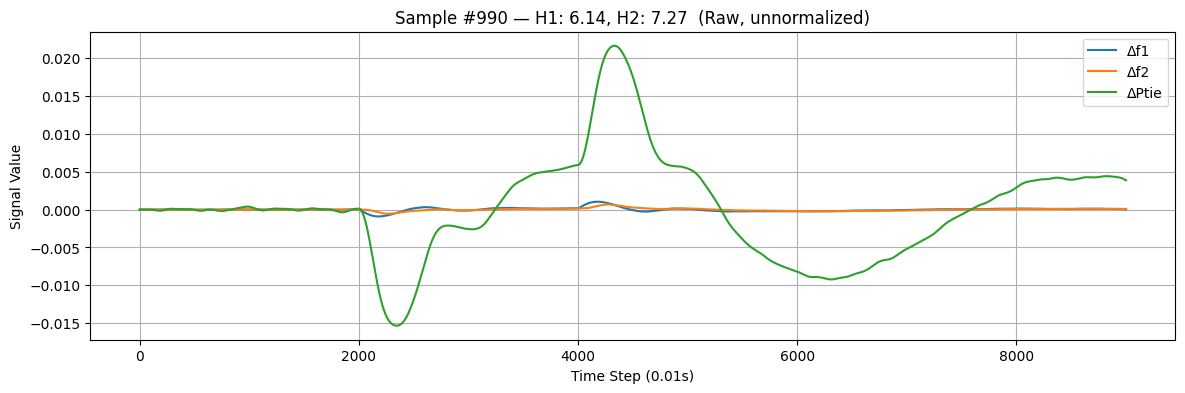

In [ ]:
plot_sample(idx=990, X=X_old, Y=Y_old, title_suffix=" (Raw, unnormalized)")

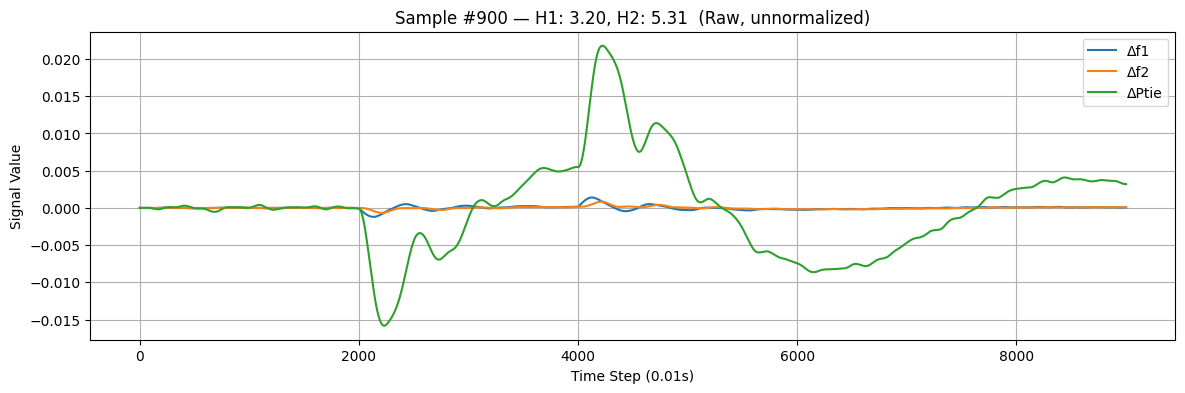

In [ ]:
plot_sample(idx=900, X=X_old, Y=Y_old, title_suffix=" (Raw, unnormalized)")

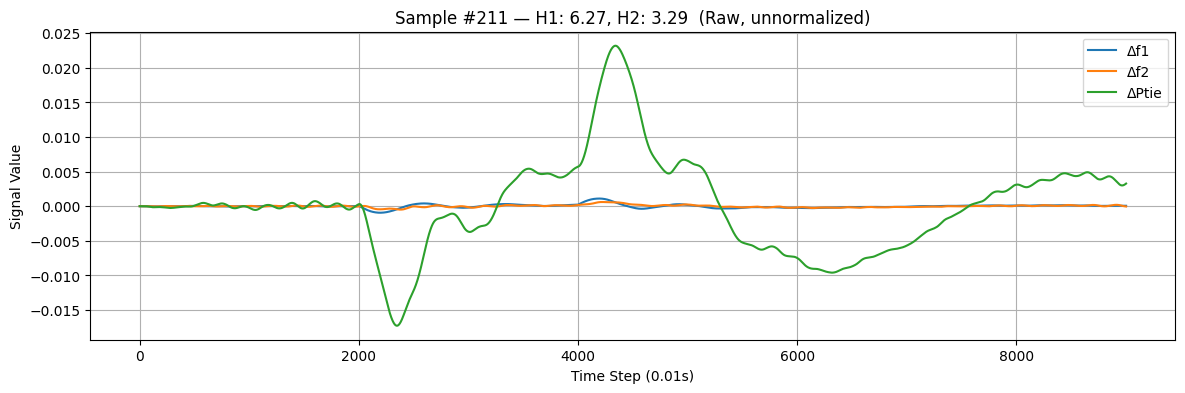

In [ ]:
plot_sample(idx=211, X=X_old, Y=Y_old, title_suffix=" (Raw, unnormalized)")

New code


In [ ]:
# # Suppose you’ve already loaded X, Y as in your script:
# # X has shape (N, 6001, 5), Y has shape (N, 2)



# # You can also add a suffix, e.g.:
# plot_sample(42, X, Y, title_suffix="(Disturbance demo)")


In [ ]:
import pandas as pd

Statistic_Data = pd.read_csv('simulink_features_hydro_power_sources.csv')

Statistic_Data.head()

,f1_mean,f1_std,f1_max,f1_min,f1_ptp,f1_rms,f1_max_rocof,f1_nadir_time,f1_rms_ratio,f2_mean,...,ptie_std,ptie_max,ptie_min,ptie_ptp,ptie_rms,ptie_max_rocof,ptie_nadir_time,ptie_rms_ratio,H1,H2
0,0.000004,0.000300,0.001370,-0.001281,0.002651,0.000300,10013.946289,21.29,0.300463,4.926354e-07,...,0.006449,0.022302,-0.016078,0.038380,0.006449,10000.098633,22.43,0.733377,3.169067,4.289126
1,0.000005,0.000243,0.000938,-0.000806,0.001745,0.000243,10000.167969,22.15,0.390343,1.312806e-06,...,0.006891,0.021484,-0.015286,0.036771,0.006890,9999.950195,24.19,0.759956,7.892919,7.670897
2,0.000005,0.000246,0.000987,-0.000813,0.001800,0.000246,10000.038086,22.04,0.406083,1.123467e-06,...,0.006822,0.021888,-0.015903,0.037791,0.006821,10000.078125,24.01,0.772319,7.598004,5.541729
3,0.000005,0.000244,0.000982,-0.000834,0.001817,0.000244,10000.141602,22.02,0.390427,1.377188e-06,...,0.006799,0.021345,-0.015108,0.036453,0.006799,10000.074219,23.81,0.766609,7.207389,7.465922
4,0.000004,0.000263,0.001045,-0.000872,0.001916,0.000263,10000.765625,22.17,0.373461,1.100892e-06,...,0.006938,0.023024,-0.016742,0.039767,0.006938,10000.100586,23.54,0.748275,7.267733,3.340430


In [ ]:
Statistic_Data.tail()

,f1_mean,f1_std,f1_max,f1_min,f1_ptp,f1_rms,f1_max_rocof,f1_nadir_time,f1_rms_ratio,f2_mean,...,ptie_std,ptie_max,ptie_min,ptie_ptp,ptie_rms,ptie_max_rocof,ptie_nadir_time,ptie_rms_ratio,H1,H2
995,0.000004,0.000279,0.001241,-0.001080,0.002320,0.000279,10008.002930,21.57,0.316448,5.868364e-07,...,0.006576,0.022644,-0.016369,0.039013,0.006576,10000.117188,23.01,0.743549,4.195250,4.548054
996,0.000004,0.000265,0.001092,-0.000992,0.002084,0.000265,10004.354492,21.81,0.342722,8.752507e-07,...,0.006637,0.022523,-0.017213,0.039736,0.006637,10000.053711,23.39,0.728031,5.205702,3.975487
997,0.000004,0.000248,0.001067,-0.000974,0.002041,0.000248,10000.703125,21.63,0.349559,9.946992e-07,...,0.006528,0.021123,-0.015570,0.036693,0.006528,10000.074219,22.79,0.742903,4.778116,7.864991
998,0.000005,0.000253,0.001044,-0.000883,0.001927,0.000253,10000.458984,21.96,0.385168,1.143806e-06,...,0.006743,0.021719,-0.015843,0.037562,0.006743,10000.077148,23.76,0.758627,6.525545,6.214193
999,0.000004,0.000256,0.001067,-0.000958,0.002025,0.000256,10131.325195,21.65,0.344746,7.950728e-07,...,0.006632,0.021696,-0.015622,0.037319,0.006632,10000.071289,23.41,0.723435,5.418651,6.016595


Because the calculation of ROCOF is wrong we drop it from our dataset

In [1]:
import pandas as pd
df = pd.read_csv("simulink_features_hydro_power_sources.csv")
rocof_cols = [c for c in df.columns if c.endswith("_max_rocof")]
df_clean = df.drop(columns=rocof_cols)  # προτείνεται να πετάξεις και το ptie_max_rocof αν υπάρχει
df_clean.to_csv("simulink_features_hydro_power_sources_FINAL.csv", index=False)
print("Έτοιμο: simulink_features_hydro_power_sources_FINAL.csv")


Έτοιμο: simulink_features_hydro_power_sources_FINAL.csv


In [3]:
df = df_clean.copy()

In [4]:
df.shape

(1000, 26)

##PREPROCESS

CHECKING FOR INSTABILITY INPUT SEQUENCES

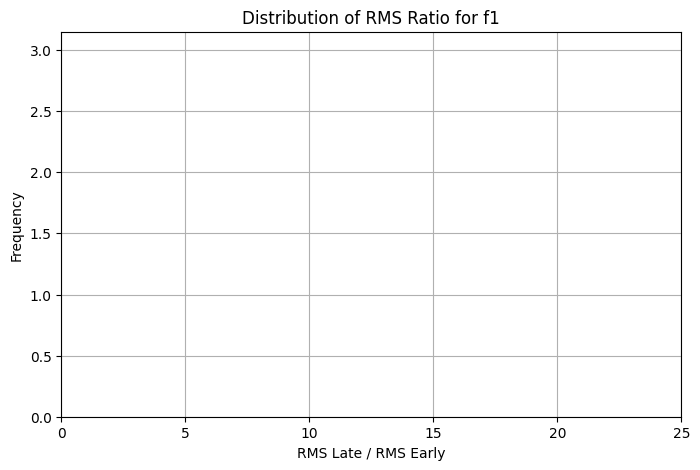

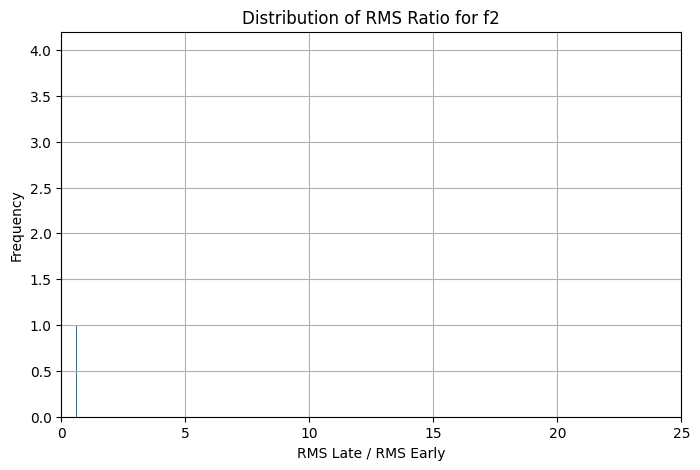

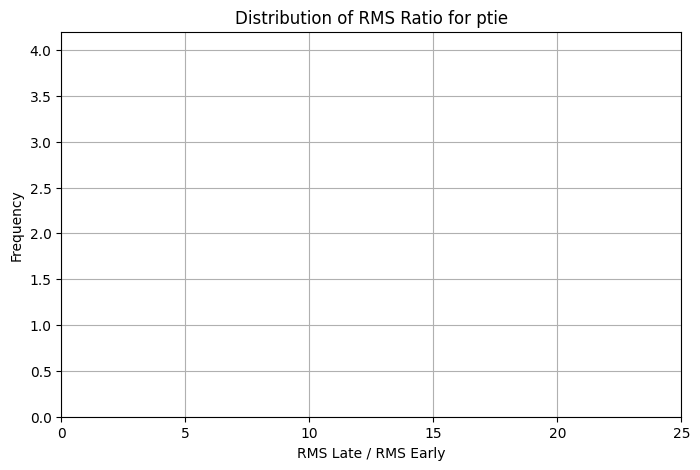

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

#df = pd.read_csv('simulink_feature_dataset_1000_outliers.csv')

for channel in ['f1', 'f2', 'ptie']:
    plt.figure(figsize=(8, 5))
    plt.hist(df[f'{channel}_rms_ratio'], bins=10000)
    plt.title(f'Distribution of RMS Ratio for {channel}')
    plt.xlabel('RMS Late / RMS Early')
    plt.ylabel('Frequency')
    plt.xlim(0, 25)  # Adjust as needed
    plt.grid(True)
    plt.show()


In [ ]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data and features
with h5py.File('simulink_dataset_different_disturbances_2_hydro_sources_probe_signal.mat', 'r') as f:
    all_data = f['all_data'][:]  # (3, 6001, N)

X = torch.tensor(np.transpose(all_data, (2, 1, 0)), dtype=torch.float32)  # (N, 6001, 3)
df = pd.read_csv('simulink_features_hydro_power_sources.csv')

# Select samples with high RMS ratio for any channel
threshold = 2
high_ratio_idx = df[
    (df['f1_rms_ratio'] > threshold) |
    (df['f2_rms_ratio'] > threshold) |
    (df['ptie_rms_ratio'] > threshold)
].index

print(f"Found {len(high_ratio_idx)} sequences with RMS ratio > {threshold}")

# Plot a few high-ratio sequences with H1 and H2 in the title
for idx in high_ratio_idx[:3]:  # Plot first 3
    h1_val = df.loc[idx, 'H1']
    h2_val = df.loc[idx, 'H2']

    plt.figure(figsize=(12, 5))
    for j, name in enumerate(['Δf1', 'Δf2', 'ΔPtie']):
        plt.plot(X[idx, :, j], label=name)
    plt.title(f"Sample #{idx} — H1: {h1_val:.2f}, H2: {h2_val:.2f} (RMS ratio > {threshold})")
    plt.xlabel("Time Step")
    plt.ylabel("Signal Value")
    plt.legend()
    plt.grid(True)
    plt.show()


Found 0 sequences with RMS ratio > 2


In [6]:
import pandas as pd

#df = pd.read_csv('simulink_feature_dataset_1000_outliers.csv')

threshold = 2
unstable_counts = {
    channel: (df[f'{channel}_rms_ratio'] > threshold).sum()
    for channel in ['f1', 'f2', 'ptie']
}

total_unstable = (df[['f1_rms_ratio', 'f2_rms_ratio', 'ptie_rms_ratio']] > threshold).any(axis=1).sum()

print(f"Number of unstable sequences with RMS ratio > {threshold}:")
for ch, count in unstable_counts.items():
    print(f"  {ch}: {count}")

print(f"Total (any channel): {total_unstable}")


Number of unstable sequences with RMS ratio > 2:
  f1: 0
  f2: 0
  ptie: 0
Total (any channel): 0


In [7]:
# Assuming df is your existing DataFrame
df = df[
    (df['f1_rms_ratio'] <= 2) &
    (df['f2_rms_ratio'] <= 2) &
    (df['ptie_rms_ratio'] <= 2)
]

print(f"Filtered DataFrame shape: {df.shape}")


Filtered DataFrame shape: (1000, 26)


#CORRATION MATRIX

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

def filter_features_by_correlation(df, target_columns=['H1', 'H2'], threshold=0.3,
                                 verbose=True, plot_corr=True, figsize=(12, 8)):
    """
    Filter features based on their absolute correlation with target columns.

    Parameters:
    - df: pandas DataFrame containing both features and targets
    - target_columns: list of target column names (default ['H1', 'H2'])
    - threshold: minimum absolute correlation to keep a feature (default 0.2)
    - verbose: whether to print the correlation results (default True)
    - plot_corr: whether to plot the correlation heatmap (default True)
    - figsize: size of the correlation plot (default (12, 8))

    Returns:
    - DataFrame containing only selected features and targets
    - List of selected feature names
    """
    # Compute absolute correlation matrix
    corr_matrix = df.corr().abs()

    # Select only correlations of features with targets
    feature_corr = corr_matrix[target_columns].drop(index=target_columns)

    if verbose:
        print("🔍 Correlation of features with targets:\n")
        print(feature_corr)

    # Plot correlation heatmap
    if plot_corr:
        plt.figure(figsize=figsize)
        sns.heatmap(feature_corr, annot=True, cmap='coolwarm',
                   vmin=0, vmax=1, linewidths=0.5)
        plt.title(f"Absolute Correlation with Targets (Threshold = {threshold})")
        plt.show()

    # Keep features where correlation with any target is above threshold
    mask = (feature_corr > threshold).any(axis=1)
    selected_features = feature_corr[mask].index.tolist()

    if verbose:
        print(f"\n✅ Selected features (correlation > {threshold}):", selected_features)

    # Return filtered dataframe and selected features
    return df[selected_features + target_columns], selected_features

🔍 Correlation of features with targets:

                       H1        H2
f1_mean          0.852725  0.039741
f1_std           0.597962  0.657695
f1_max           0.901932  0.175397
f1_min           0.957301  0.132195
f1_ptp           0.942121  0.155794
f1_rms           0.597725  0.657820
f1_nadir_time    0.953610  0.186858
f1_rms_ratio     0.840680  0.351368
f2_mean          0.844029  0.081460
f2_std           0.164344  0.242619
f2_max           0.861886  0.271652
f2_min           0.888118  0.290688
f2_ptp           0.896441  0.288237
f2_rms           0.164009  0.242600
f2_nadir_time    0.198902  0.019013
f2_rms_ratio     0.484933  0.445062
ptie_mean        0.918258  0.042702
ptie_std         0.955632  0.269165
ptie_max         0.102899  0.846863
ptie_min         0.070170  0.870816
ptie_ptp         0.020711  0.891076
ptie_rms         0.955659  0.269070
ptie_nadir_time  0.935189  0.180951
ptie_rms_ratio   0.296592  0.453973


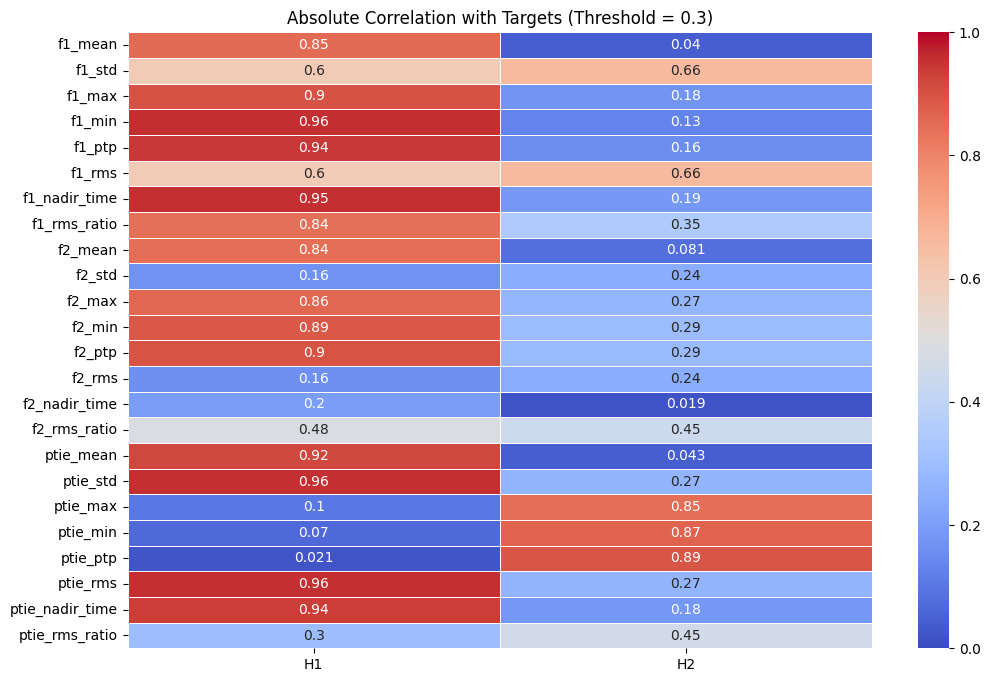


✅ Selected features (correlation > 0.3): ['f1_mean', 'f1_std', 'f1_max', 'f1_min', 'f1_ptp', 'f1_rms', 'f1_nadir_time', 'f1_rms_ratio', 'f2_mean', 'f2_max', 'f2_min', 'f2_ptp', 'f2_rms_ratio', 'ptie_mean', 'ptie_std', 'ptie_max', 'ptie_min', 'ptie_ptp', 'ptie_rms', 'ptie_nadir_time', 'ptie_rms_ratio']


In [9]:
# With default visualization
df_filtered, selected_features = filter_features_by_correlation(df)




In [10]:
df_filtered.shape

(1000, 23)

In [ ]:
# import pandas as pd
# import numpy as np

# # Set random seed for reproducibility
# np.random.seed(42)

# # Create the sampled DataFrames
# df2 = df_filtered.drop(np.random.choice(df_filtered.index, size=int(len(df_filtered)*0.25), replace=False))
# df3 = df_filtered.drop(np.random.choice(df_filtered.index, size=int(len(df_filtered)*0.50), replace=False))
# df4 = df_filtered.drop(np.random.choice(df_filtered.index, size=int(len(df_filtered)*0.75), replace=False))

# # Verify the sizes
# print(f"Original size: {len(df)} rows")
# print(f"df2 (25% dropped): {len(df2)} rows (should be ~541)")
# print(f"df3 (50% dropped): {len(df3)} rows (should be ~361)")
# print(f"df4 (75% dropped): {len(df4)} rows (should be ~180)")

#EVALUATION

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate_predictions(Y_true, Y_pred, names=['H1', 'H2'], verbose=True):
    """
    Evaluate predictions using various metrics and print the results.

    Parameters:
    - Y_true: numpy array of true values
    - Y_pred: numpy array of predicted values
    - names: list of names for each output variable
    - verbose: whether to print the results (default True)

    Returns:
    - Dictionary containing all evaluation metrics for each output
    """
    results = {}

    for i, name in enumerate(names):
        true = Y_true[:, i]
        pred = Y_pred[:, i]

        metrics = {
            'R2': r2_score(true, pred),
            'MAE': mean_absolute_error(true, pred),
            'RMSE': np.sqrt(mean_squared_error(true, pred)),
            'MAPE': mean_absolute_percentage_error(true, pred)*100
        }

        results[name] = metrics

        if verbose:
            print(f"{name} → R²: {metrics['R2']:.5f}, RMSE: {metrics['RMSE']:.5f}, "
                  f"MAE: {metrics['MAE']:.5f}, MAPE: {metrics['MAPE']:.2f}%")




    return results

#COMPARASION DATAFRAME

In [12]:
def create_comparison_df(Y_true, Y_pred, names=['H1', 'H2']):
    """
    Create a DataFrame comparing actual and predicted values.

    Parameters:
    - Y_true: numpy array of true values
    - Y_pred: numpy array of predicted values
    - names: list of names for each output variable

    Returns:
    - Pandas DataFrame with actual and predicted values side by side
    """
    data = {}
    for i, name in enumerate(names):
        data[f'{name}_actual'] = Y_true[:, i]
        data[f'{name}_pred'] = Y_pred[:, i]

    return pd.DataFrame(data)

#PLOTTER OF ESTIMATIONS

In [13]:
def plot_predictions(Y_true, Y_pred, target_names=['H1', 'H2'],
                    figsize=(12, 5), alpha=0.6, color='b',
                    diagonal_line=True, grid=True, tight_layout=True):
    """
    Create actual vs. predicted scatter plots for multiple targets.

    Parameters:
    - Y_true: Array of true values (2D array with shape [n_samples, n_targets])
    - Y_pred: Array of predicted values (same shape as Y_true)
    - target_names: List of names for each target variable
    - figsize: Figure size (width, height)
    - alpha: Transparency of scatter points
    - color: Color of scatter points
    - diagonal_line: Whether to plot the ideal prediction line
    - grid: Whether to show grid lines
    - tight_layout: Whether to adjust subplot spacing

    Returns:
    - matplotlib figure object
    """
    n_targets = Y_true.shape[1]
    fig, axes = plt.subplots(1, n_targets, figsize=figsize)

    if n_targets == 1:
        axes = [axes]  # Ensure axes is iterable for single target case

    for i, ax in enumerate(axes):
        true = Y_true[:, i]
        pred = Y_pred[:, i]

        # Scatter plot
        ax.scatter(true, pred, alpha=alpha, color=color)

        # Calculate R² score
        r2 = r2_score(true, pred)

        # Plot ideal prediction line
        if diagonal_line:
            min_val = min(true.min(), pred.min())
            max_val = max(true.max(), pred.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--',
                   label='Ideal prediction')

        # Labels and title
        ax.set_xlabel(f"True {target_names[i]}")
        ax.set_ylabel(f"Predicted {target_names[i]}")
        ax.set_title(f"{target_names[i]} Prediction\n(R² = {r2:.3f})")

        if grid:
            ax.grid(True)

        if diagonal_line:
            ax.legend()

    if tight_layout:
        plt.tight_layout()

    return fig

#BOXPLOT

In [14]:
def plot_error_analysis(Y_true, Y_pred, target_names=['H1', 'H2'],
                       plot_type='boxplot', figsize=(10, 6),
                       show_stats=True, palette='Set2'):
    """
    Visualize prediction errors with multiple plot types and statistics.

    Parameters:
    - Y_true: Array of true values
    - Y_pred: Array of predicted values
    - target_names: List of target names
    - plot_type: 'boxplot', 'violin', or 'combined'
    - figsize: Figure dimensions
    - show_stats: Whether to print error statistics
    - palette: Color palette name

    Returns:
    - matplotlib figure object
    - dictionary of error statistics
    """
    # Calculate absolute errors for each target
    errors = np.abs(Y_pred - Y_true)
    stats = {}

    # Calculate error statistics
    for i, name in enumerate(target_names):
        stats[name] = {
            'mean_error': np.mean(errors[:, i]),
            'median_error': np.median(errors[:, i]),
            'max_error': np.max(errors[:, i]),
            'std_dev': np.std(errors[:, i])
        }

    if show_stats:
        print("📊 Error Statistics:")
        for name in target_names:
            print(f"\n{name}:")
            print(f"  Mean Absolute Error: {stats[name]['mean_error']:.4f}")
            print(f"  Median Absolute Error: {stats[name]['median_error']:.4f}")
            print(f"  Max Error: {stats[name]['max_error']:.4f}")
            print(f"  Standard Deviation: {stats[name]['std_dev']:.4f}")

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot based on selected type
    if plot_type == 'boxplot':
        bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],
                       labels=[f'{name} Error' for name in target_names],
                       patch_artist=True)
        # Add colors
        colors = sns.color_palette(palette, len(target_names))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

    elif plot_type == 'violin':
        vp = ax.violinplot([errors[:, i] for i in range(len(target_names))],
                         showmedians=True)
        colors = sns.color_palette(palette, len(target_names))
        for pc, color in zip(vp['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        ax.set_xticks(np.arange(1, len(target_names)+1))
        ax.set_xticklabels([f'{name} Error' for name in target_names])

    elif plot_type == 'combined':
        positions = np.arange(1, len(target_names)+1)
        # Violin plot
        vp = ax.violinplot([errors[:, i] for i in range(len(target_names))],
                         positions=positions-0.15,
                         widths=0.3,
                         showmedians=True)
        # Box plot
        bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],
                      positions=positions+0.15,
                      widths=0.2,
                      patch_artist=True)

        # Styling
        colors = sns.color_palette(palette, len(target_names))
        for pc, color in zip(vp['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_alpha(0.5)

        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax.set_xticks(positions)
        ax.set_xticklabels([f'{name} Error' for name in target_names])

    # Common formatting
    ax.set_ylabel('Absolute Error')
    ax.set_title('Prediction Error Analysis')
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    return fig, stats

#CDF PLOTTER

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List, Dict, Optional

# This function plots the CDF of multiple datasets provided in a dictionary.
def plot_cdf(data_dict: dict, title: str = 'CDF Plot', xlabel: str = 'Values',
             ylabel: str = 'Cumulative Probability', figsize=(8, 6), grid=True) -> plt.Figure:
    """
    Plots the Cumulative Distribution Function (CDF) for multiple datasets.

    Parameters:
    - data_dict: Dictionary where keys are labels and values are arrays of data.
    - title: Title of the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - figsize: Figure size.
    - grid: Whether to show grid.

    Returns:
    - matplotlib Figure object
    """
    fig, ax = plt.subplots(figsize=figsize)

    for label, data in data_dict.items():
        # Filter out NaN/inf just in case
        data = data[np.isfinite(data)]
        if len(data) == 0:
            print(f"Warning: No finite data for label '{label}'. Skipping.")
            continue

        sorted_data = np.sort(data)
        # Calculate CDF as the empirical CDF
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        ax.plot(sorted_data, cdf, label=label)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    if grid:
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    return fig

# The plot_error_cdfs function remains the same, as it now calls the correctly
# structured plot_cdf function.
def plot_error_cdfs(Y_true: np.ndarray,
                   Y_pred: np.ndarray,
                   target_names: Optional[List[str]] = None,
                   **kwargs) -> plt.Figure:
    """
    Calculate absolute errors and plot their CDFs using the generic plot_cdf function.

    Parameters:
    - Y_true: Array of true values (shape [n_samples, n_targets])
    - Y_pred: Array of predicted values (same shape as Y_true)
    - target_names: Optional list of target names
    - **kwargs: Additional arguments for plot_cdf()

    Returns:
    - matplotlib Figure object
    """
    # Calculate absolute errors for each target
    errors = np.abs(Y_pred - Y_true)

    # Default target names
    if target_names is None:
        target_names = [f'Target {i+1}' for i in range(Y_true.shape[1])]
    elif len(target_names) != Y_true.shape[1]:
         print(f"Warning: target_names length ({len(target_names)}) does not match number of targets ({Y_true.shape[1]}). Using default names.")
         target_names = [f'Target {i+1}' for i in range(Y_true.shape[1])]


    # Create error dictionary for the generic plotter
    error_dict = {f'{name} Error': errors[:, i]
                 for i, name in enumerate(target_names)}

    # Plot using the generic CDF function
    # Pass the error_dict and any extra kwargs
    return plot_cdf(error_dict, xlabel='Absolute Error', title='CDF of Absolute Prediction Errors', **kwargs)

# Now you can use it like this (this part is unchanged):
# fig = plot_error_cdfs(Y_test, Y_pred, target_names=['H1', 'H2'])

#SPLITTING AND SCALING

In [16]:
X = df_filtered.iloc[:, :-2].values
Y = df_filtered.iloc[:, -2:].values

print(X.shape)
print(Y.shape)


(1000, 21)
(1000, 2)


In [17]:
# X = df2.iloc[:, :-2].values
# Y = df2.iloc[:, -2:].values

# print(X.shape)
# print(Y.shape)


In [18]:
from sklearn.model_selection import train_test_split

# === Train/test split ===
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [19]:
Y_test.shape


(300, 2)

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Y_train_scaled = scaler.fit_transform(Y_train)
Y_test_scaled = scaler.transform(Y_test)

#ESTIMATION MODELS






##RANDOM FOREST

In [21]:
# === Train random forest ===

from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, Y_train_scaled)

# === Predict and evaluate ===
Y_pred_scaled = rf.predict(X_test_scaled)


Y_pred = scaler.inverse_transform(Y_pred_scaled)
Y_true = scaler.inverse_transform(Y_test_scaled)

In [22]:
# Example usage:
results = evaluate_predictions(Y_true, Y_pred)

H1 → R²: 0.99311, RMSE: 0.12370, MAE: 0.09672, MAPE: 1.88%
H2 → R²: 0.96067, RMSE: 0.29017, MAE: 0.22586, MAPE: 4.57%


In [23]:
# Example usage:
comparison_df = create_comparison_df(Y_test, Y_pred)
print(comparison_df)

     H1_actual   H1_pred  H2_actual   H2_pred
0     5.978650  6.010506   4.788697  4.563659
1     3.457886  3.741139   3.927600  3.546989
2     3.446417  3.557552   5.697599  5.490955
3     3.290314  3.335533   7.668087  7.621718
4     7.843580  7.800806   5.183856  4.565853
..         ...       ...        ...       ...
295   4.857700  4.803633   7.879422  7.580663
296   4.142785  4.129982   5.089049  5.207753
297   4.210995  4.343668   4.612836  5.015919
298   7.412953  7.361345   6.282756  6.221639
299   7.386855  7.522523   4.482807  4.727612

[300 rows x 4 columns]


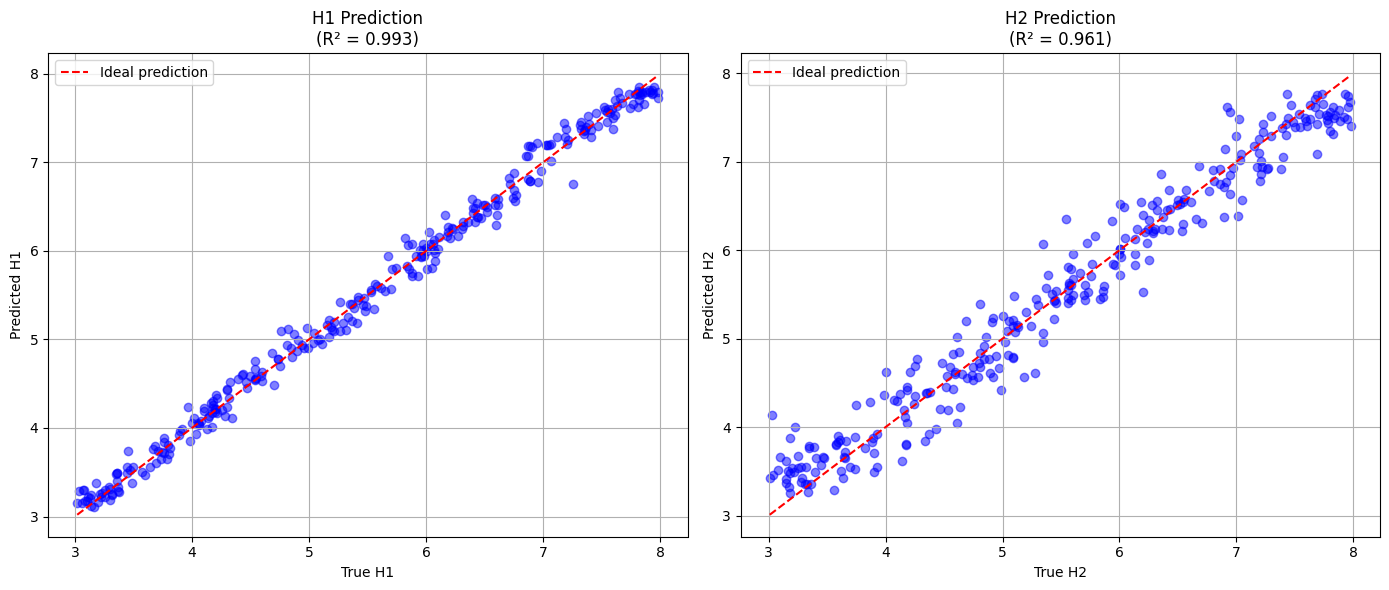

In [24]:
# Customized plot
fig = plot_predictions(Y_test, Y_pred,
                      target_names=['H1', 'H2'],
                      figsize=(14, 6),
                      alpha=0.5,
                      color='blue')

📊 Error Statistics:

H1:
  Mean Absolute Error: 0.0967
  Median Absolute Error: 0.0810
  Max Error: 0.5048
  Standard Deviation: 0.0771

H2:
  Mean Absolute Error: 0.2259
  Median Absolute Error: 0.1992
  Max Error: 1.1120
  Standard Deviation: 0.1822


/tmp/ipython-input-2910689032.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],


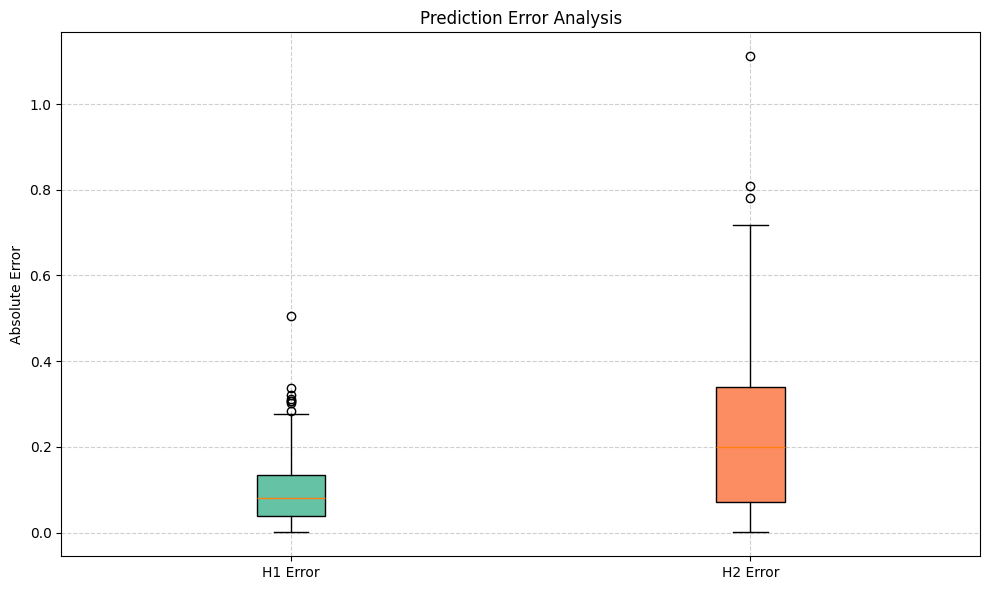

In [25]:
# Basic boxplot
fig, stats = plot_error_analysis(Y_test, Y_pred)

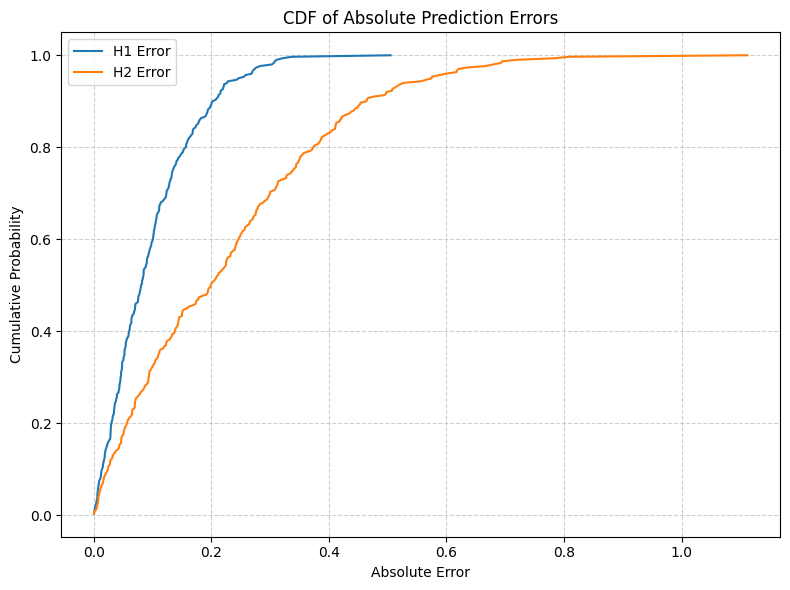

In [26]:
fig = plot_error_cdfs(Y_test, Y_pred, target_names=['H1', 'H2'])

| **Absolute Error (x)** | **Cumulative Probability (y)** | **Interpretation**                   |
| ---------------------- | ------------------------------ | ------------------------------------ |
| 0.05                   | 0.40                           | 40% of predictions have error ≤ 0.05 |
| 0.10                   | 0.75                           | 75% of predictions have error ≤ 0.10 |
| 0.20                   | 0.90                           | 90% of predictions have error ≤ 0.20 |
| 0.40                   | 0.98                           | 98% of predictions have error ≤ 0.40 |
| 1.00                   | 1.00                           | 100% of predictions have error ≤ 1.0 |


##MAE AS A FUCTION OF NUMBER OF SAMPLES

In [27]:
X.shape

(1000, 21)

##LINEAR REGRESSION

H1 → R²: 0.99228, RMSE: 0.13094, MAE: 0.09973, MAPE: 1.91%
H2 → R²: 0.90431, RMSE: 0.45263, MAE: 0.35163, MAPE: 7.23%
-------------------------------------------
     H1_actual   H1_pred  H2_actual   H2_pred
0     5.978650  5.980876   4.788697  4.462037
1     3.457886  3.771521   3.927600  3.797517
2     3.446417  3.630317   5.697599  5.910432
3     3.290314  3.316278   7.668087  7.151475
4     7.843580  8.213230   5.183856  5.399625
..         ...       ...        ...       ...
295   4.857700  4.870424   7.879422  7.820927
296   4.142785  4.146617   5.089049  5.231392
297   4.210995  4.230518   4.612836  4.857303
298   7.412953  7.339408   6.282756  5.827724
299   7.386855  7.426020   4.482807  5.430494

[300 rows x 4 columns]
-------------------------------------------
📊 Error Statistics:

H1:
  Mean Absolute Error: 0.0997
  Median Absolute Error: 0.0789
  Max Error: 0.4935
  Standard Deviation: 0.0849

H2:
  Mean Absolute Error: 0.3516
  Median Absolute Error: 0.2730
  Max Error: 1.

/tmp/ipython-input-2910689032.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],


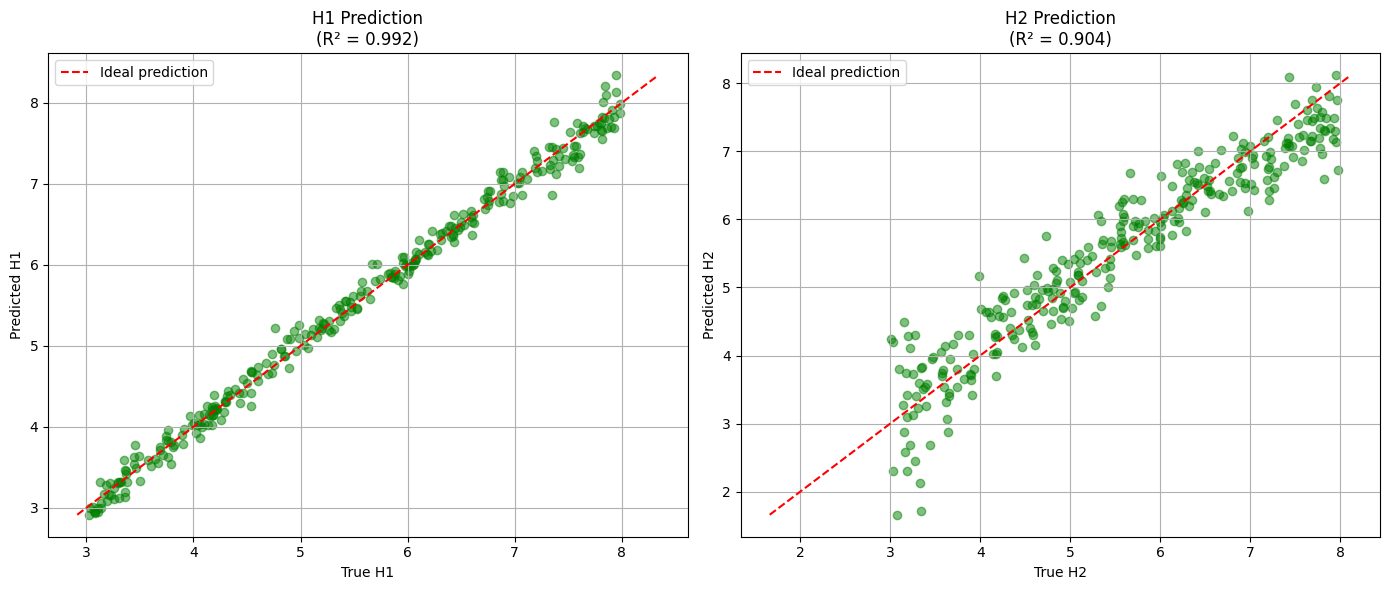

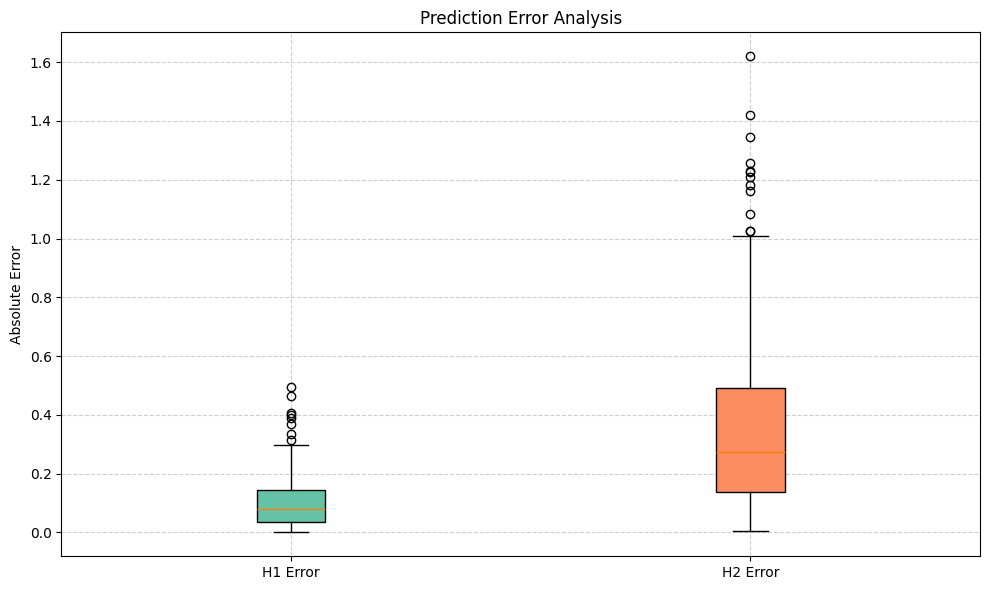

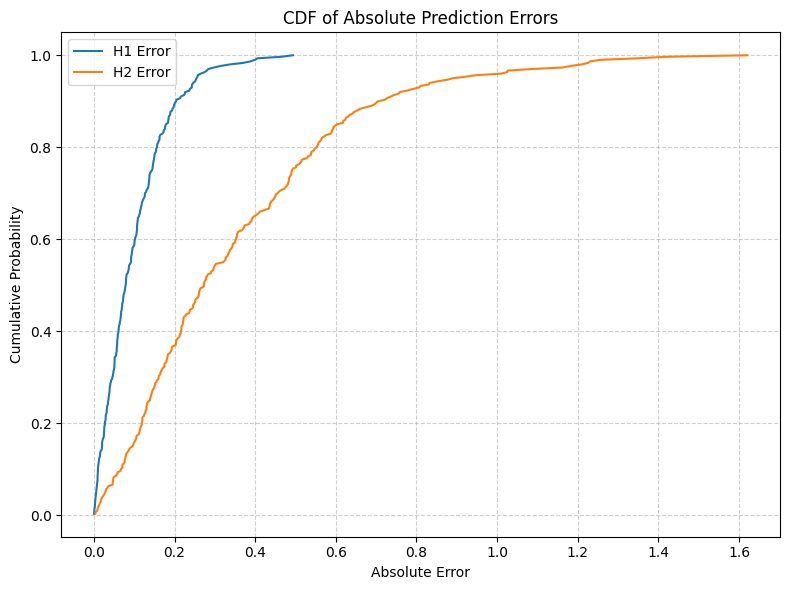

In [28]:
from sklearn.linear_model import LinearRegression



# Train Linear Regression
model = LinearRegression()
model.fit(X_train_scaled, Y_train)

# Predictions
Y_pred = model.predict(X_test_scaled)
Y_true = Y_test.copy()


results = evaluate_predictions(Y_true, Y_pred)

print("-------------------------------------------")
comparison_df = create_comparison_df(Y_test, Y_pred)
print(comparison_df)

print("-------------------------------------------")

# Customized plot
fig = plot_predictions(Y_test, Y_pred,
                      target_names=['H1', 'H2'],
                      figsize=(14, 6),
                      alpha=0.5,
                      color='green')

# Basic boxplot
fig, stats = plot_error_analysis(Y_test, Y_pred)

fig = plot_error_cdfs(Y_test, Y_pred, target_names=['H1', 'H2'])


In [29]:
X.shape

(1000, 21)

##XGBOOST

In [30]:
import xgboost as xgb



In [31]:


# === Separate features and targets ===
X = df_filtered.drop(columns=['H1', 'H2']).values
Y = df_filtered[['H1', 'H2']].values

# === Train/val/test split ===
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# === Min-Max Scaling ===
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled   = X_scaler.transform(X_val)
X_test_scaled  = X_scaler.transform(X_test)

Y_train_scaled = Y_scaler.fit_transform(Y_train)
Y_val_scaled   = Y_scaler.transform(Y_val)
Y_test_scaled  = Y_scaler.transform(Y_test)

# === Train a separate XGBoost model for H1 and H2 ===
models = []
for i in range(Y.shape[1]):
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train_scaled, Y_train_scaled[:, i])
    models.append(model)

# === Predict and inverse transform ===
Y_pred_scaled = np.column_stack([model.predict(X_test_scaled) for model in models])
Y_pred = Y_scaler.inverse_transform(Y_pred_scaled)
Y_true = Y_scaler.inverse_transform(Y_test_scaled)





H1 → R²: 0.99182, RMSE: 0.13234, MAE: 0.10656, MAPE: 2.16%
H2 → R²: 0.91417, RMSE: 0.41129, MAE: 0.26915, MAPE: 5.39%
-------------------------------------------
     H1_actual   H1_pred  H2_actual   H2_pred
0     7.943594  7.954821   5.603308  5.537402
1     5.420345  5.510302   3.824164  4.005495
2     5.314974  5.118865   7.401010  7.127112
3     7.743740  7.655591   7.047137  6.697444
4     3.182145  3.496272   5.666627  5.650470
..         ...       ...        ...       ...
145   3.467523  3.497044   3.328638  3.401359
146   3.314988  3.126817   5.457638  5.236761
147   7.881852  7.879220   4.122413  4.513278
148   6.403740  6.325340   5.018105  5.293222
149   6.592408  6.502268   3.592435  3.525698

[150 rows x 4 columns]
-------------------------------------------
📊 Error Statistics:

H1:
  Mean Absolute Error: 0.1066
  Median Absolute Error: 0.0905
  Max Error: 0.3897
  Standard Deviation: 0.0785

H2:
  Mean Absolute Error: 0.2691
  Median Absolute Error: 0.2002
  Max Error: 2.

/tmp/ipython-input-2910689032.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],


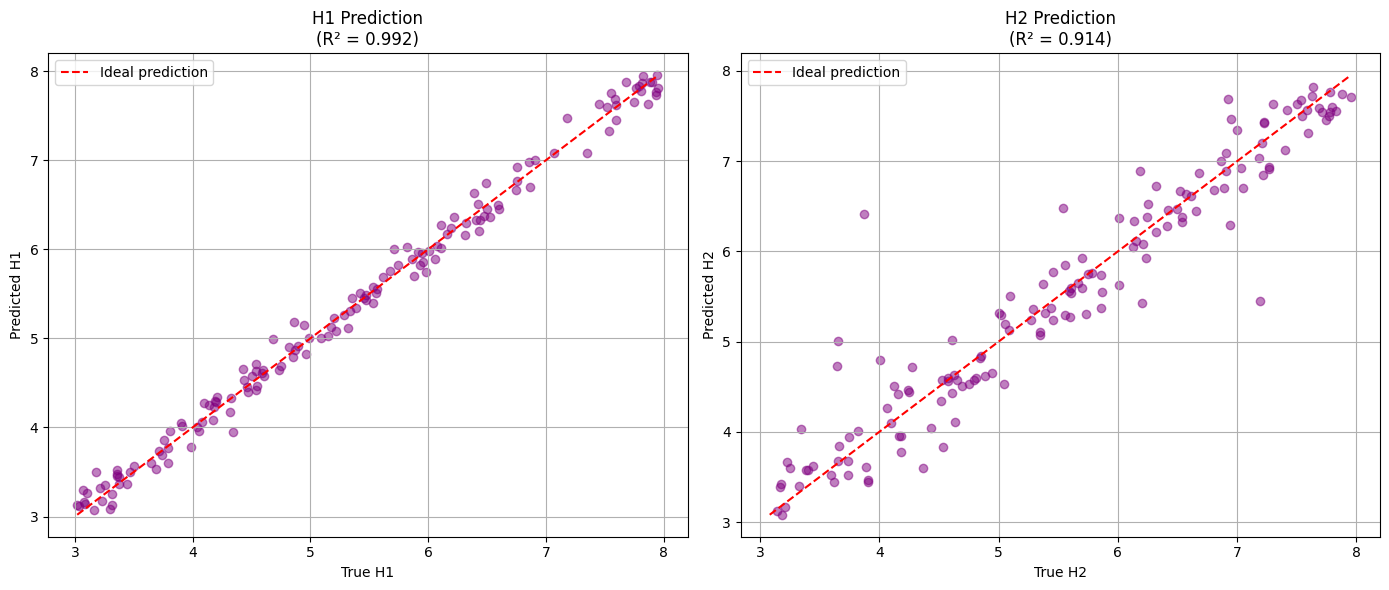

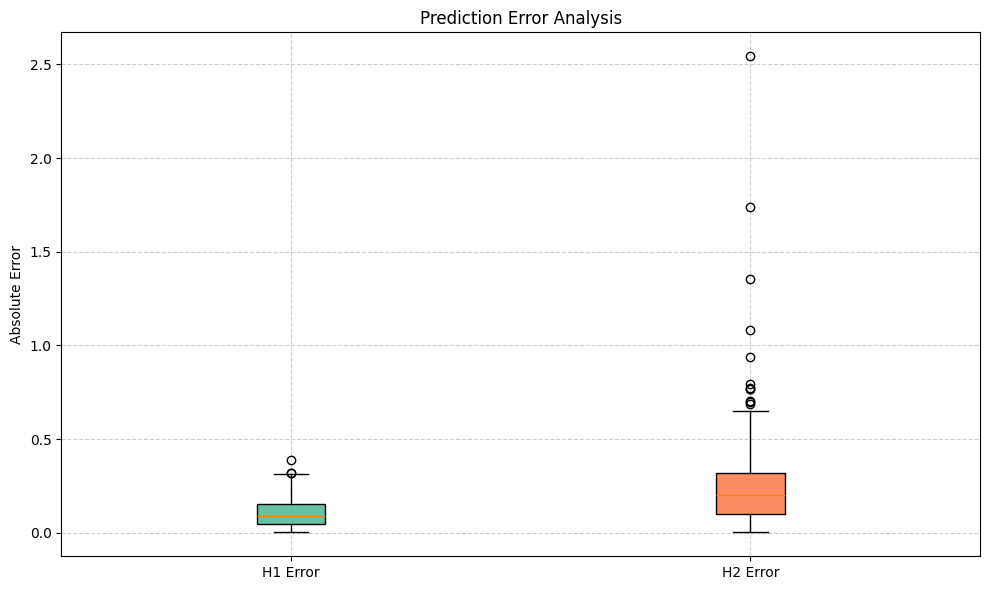

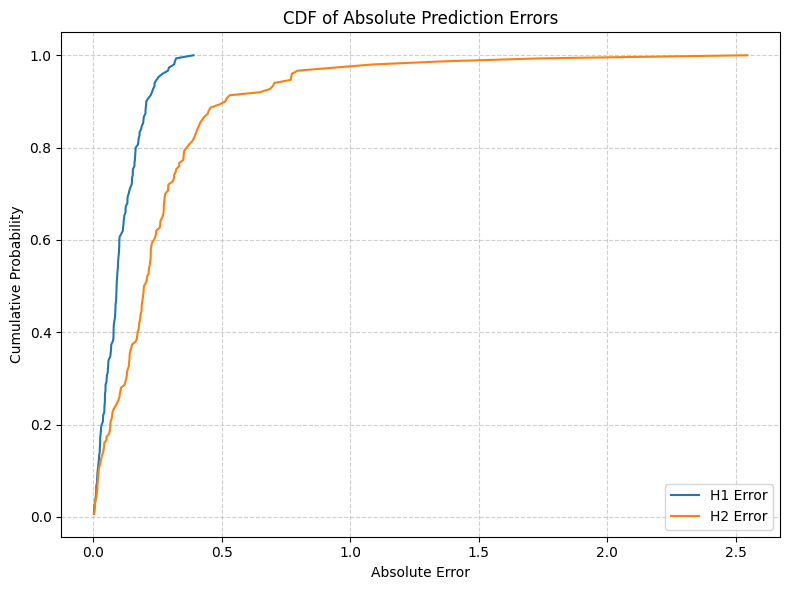

In [32]:
results = evaluate_predictions(Y_true, Y_pred)

print("-------------------------------------------")
comparison_df = create_comparison_df(Y_test, Y_pred)
print(comparison_df)

print("-------------------------------------------")

# Customized plot
fig = plot_predictions(Y_test, Y_pred,
                      target_names=['H1', 'H2'],
                      figsize=(14, 6),
                      alpha=0.5,
                      color='purple')

# Basic boxplot
fig, stats = plot_error_analysis(Y_test, Y_pred)

fig = plot_error_cdfs(Y_test, Y_pred, target_names=['H1', 'H2'])

##SVR

H1 → R²: 0.98124, RMSE: 0.20411, MAE: 0.15570, MAPE: 3.01%
H2 → R²: 0.94757, RMSE: 0.33506, MAE: 0.25895, MAPE: 5.28%
-------------------------------------------
     H1_actual   H1_pred  H2_actual   H2_pred
0     5.978650  6.007913   4.788697  4.795812
1     3.457886  3.445332   3.927600  3.540136
2     3.446417  3.697177   5.697599  5.553537
3     3.290314  3.578479   7.668087  7.537107
4     7.843580  7.135934   5.183856  4.761809
..         ...       ...        ...       ...
295   4.857700  5.070298   7.879422  7.164504
296   4.142785  4.005037   5.089049  4.971056
297   4.210995  4.217740   4.612836  4.373521
298   7.412953  7.426766   6.282756  6.396270
299   7.386855  7.270774   4.482807  4.381503

[300 rows x 4 columns]
-------------------------------------------
📊 Error Statistics:

H1:
  Mean Absolute Error: 0.1557
  Median Absolute Error: 0.1171
  Max Error: 0.7076
  Standard Deviation: 0.1320

H2:
  Mean Absolute Error: 0.2589
  Median Absolute Error: 0.2027
  Max Error: 1.

/tmp/ipython-input-2910689032.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],


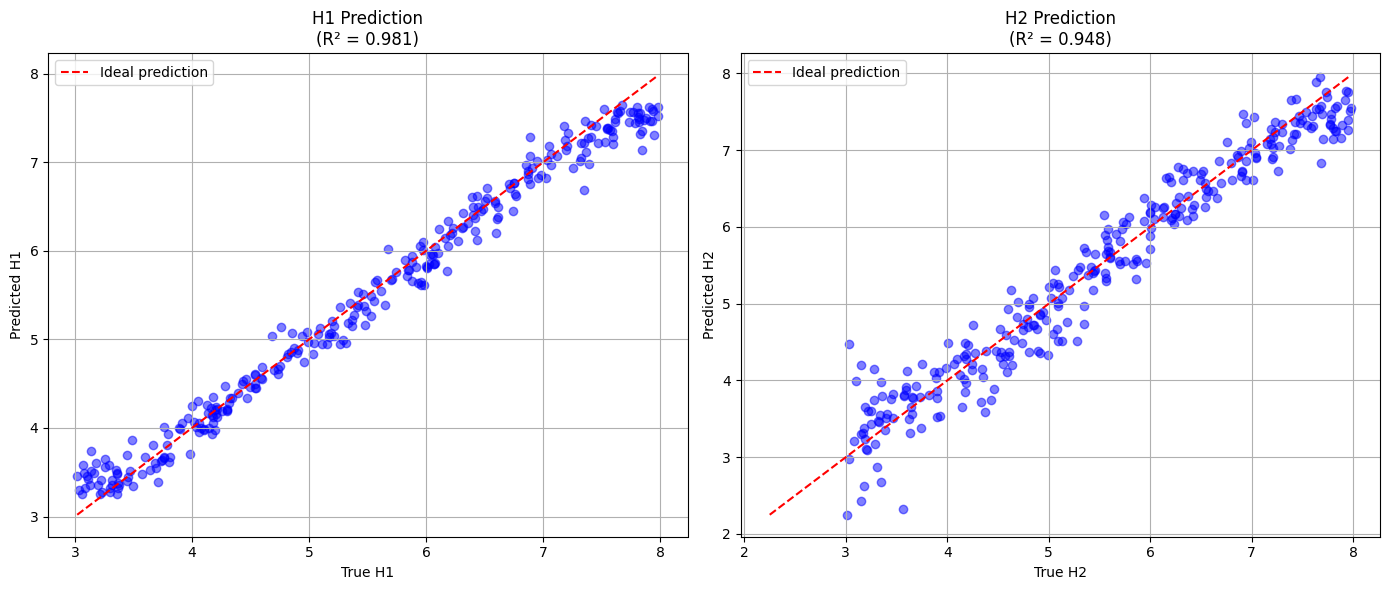

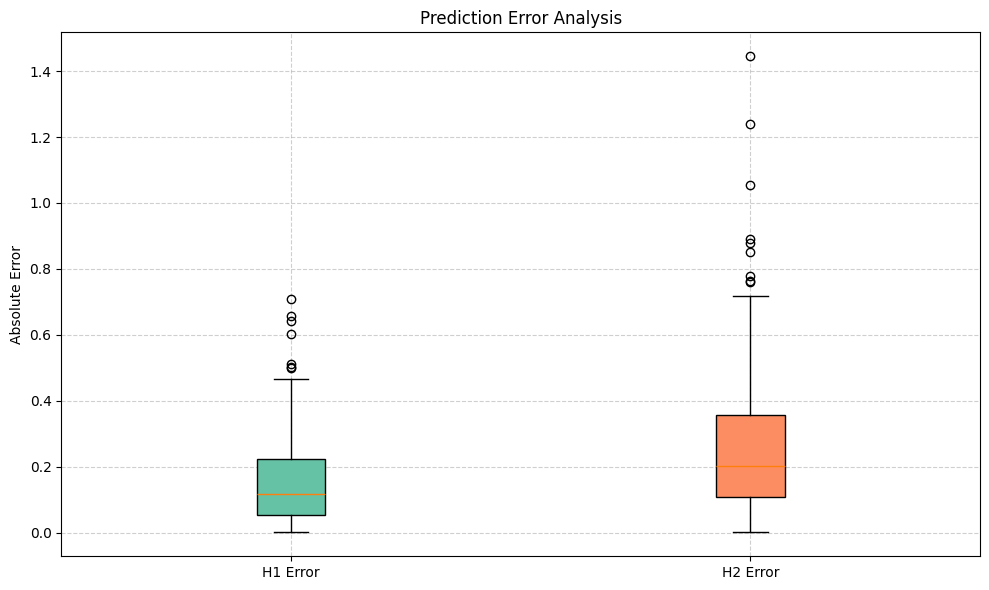

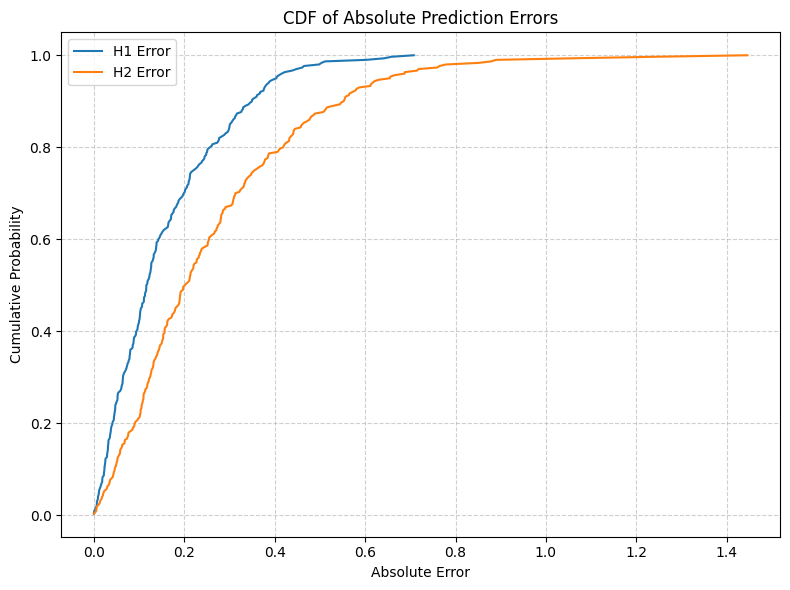

In [33]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler
import numpy as np # Import numpy

# Assuming X and Y are loaded from the .mat file as done earlier in the notebook

# === Train/test split ===
# This split determines the samples for the SVR model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale Y data as well if needed for the model
Y_train_scaled = scaler.fit_transform(Y_train)
Y_test_scaled = scaler.transform(Y_test) # Use the Y_test from THIS split

# -------------------------------
# Train Multi-Output SVR
# -------------------------------
base_svr = SVR(kernel='rbf', C=100, epsilon=0.1)
model_svr = MultiOutputRegressor(base_svr)

model_svr.fit(X_train_scaled, Y_train_scaled) # Train on scaled Y

# -------------------------------
# Predict and Inverse-Transform y
# -------------------------------
y_pred_scaled = model_svr.predict(X_test_scaled)
Y_pred = scaler.inverse_transform(y_pred_scaled)

# Use the correct Y_test from THIS split as the true values for evaluation
Y_true = Y_test # Now Y_true and Y_pred will have the same number of samples (219)

# -------------------------------
# Evaluate and Plot (assuming helper functions are defined elsewhere)
# -------------------------------
results = evaluate_predictions(Y_true, Y_pred) # Y_true and Y_pred have 219 samples

print("-------------------------------------------")
comparison_df = create_comparison_df(Y_true, Y_pred) # Use Y_true for consistency
print(comparison_df)

print("-------------------------------------------")

# Customized plot
fig = plot_predictions(Y_true, Y_pred, # Use Y_true
                      target_names=['H1', 'H2'],
                      figsize=(14, 6),
                      alpha=0.5,
                      color='blue')

# Basic boxplot
fig, stats = plot_error_analysis(Y_true, Y_pred) # Use Y_true

# Ensure Y_test is also a numpy array for plot_error_cdfs
fig = plot_error_cdfs(Y_true, Y_pred, target_names=['H1', 'H2']) # Use Y_true

##MLP with 2 layers

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler




In [35]:
X.shape

(1000, 21)

In [36]:
print("X dimensions: ",X.shape)
print("Y dimensions: ",Y.shape)

X dimensions:  (1000, 21)
Y dimensions:  (1000, 2)


In [37]:
import torch
from torch.utils.data import Dataset, DataLoader

class InertiaRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = InertiaRegressionDataset(X_train_scaled, Y_train_scaled)
test_dataset = InertiaRegressionDataset(X_test_scaled, Y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)




In [ ]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64
            ),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 2 outputs: H1 and H2
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel(input_dim=21)


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# criterion = nn.MSELoss()

# # Hyperparameters
# learning_rate = 1e-3
# weight_decay = 1e-5
# early_stop_patience = 5      # number of checks without improvement
# check_every = 30             # check every 30 batches
# best_val_loss = float('inf')
# no_improve_count = 0
# step = 0

# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=learning_rate,
#     weight_decay=weight_decay
# )

# for epoch in range(2000):
#     model.train()
#     running_loss = 0
#     for batch_x, batch_y in train_loader:
#         step += 1
#         batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#         optimizer.zero_grad()
#         output = model(batch_x)
#         loss = criterion(output, batch_y)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#         # ✅ Check validation loss every `check_every` steps
#         if step % check_every == 0:
#             model.eval()
#             val_losses = []
#             with torch.no_grad():
#                 for val_x, val_y in test_loader:  # Use test_loader as validation
#                     val_x, val_y = val_x.to(device), val_y.to(device)
#                     val_out = model(val_x)
#                     val_loss = criterion(val_out, val_y).item()
#                     val_losses.append(val_loss)

#             avg_val_loss = sum(val_losses) / len(val_losses)
#             print(f"Step {step}, Validation Loss: {avg_val_loss:.4f}")

#             if avg_val_loss < best_val_loss:
#                 best_val_loss = avg_val_loss
#                 no_improve_count = 0
#             else:
#                 no_improve_count += 1
#                 if no_improve_count >= early_stop_patience:
#                     print(f"Early stopping triggered at step {step}.")
#                     break
#             model.train()

#     print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader):.4f}")

#     if no_improve_count >= early_stop_patience:
#         print(f"Early stopping ended training at epoch {epoch+1}.")
#         break


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)




for epoch in range(1500):
    model.train()
    running_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.1707
Epoch 2, Loss: 0.0459
Epoch 3, Loss: 0.0175
Epoch 4, Loss: 0.0072
Epoch 5, Loss: 0.0054
Epoch 6, Loss: 0.0048
Epoch 7, Loss: 0.0047
Epoch 8, Loss: 0.0042
Epoch 9, Loss: 0.0039
Epoch 10, Loss: 0.0036
Epoch 11, Loss: 0.0034
Epoch 12, Loss: 0.0033
Epoch 13, Loss: 0.0032
Epoch 14, Loss: 0.0030
Epoch 15, Loss: 0.0030
Epoch 16, Loss: 0.0029
Epoch 17, Loss: 0.0028
Epoch 18, Loss: 0.0027
Epoch 19, Loss: 0.0029
Epoch 20, Loss: 0.0025
Epoch 21, Loss: 0.0024
Epoch 22, Loss: 0.0023
Epoch 23, Loss: 0.0023
Epoch 24, Loss: 0.0024
Epoch 25, Loss: 0.0023
Epoch 26, Loss: 0.0022
Epoch 27, Loss: 0.0021
Epoch 28, Loss: 0.0021
Epoch 29, Loss: 0.0021
Epoch 30, Loss: 0.0021
Epoch 31, Loss: 0.0022
Epoch 32, Loss: 0.0021
Epoch 33, Loss: 0.0020
Epoch 34, Loss: 0.0022
Epoch 35, Loss: 0.0021
Epoch 36, Loss: 0.0023
Epoch 37, Loss: 0.0019
Epoch 38, Loss: 0.0020
Epoch 39, Loss: 0.0020
Epoch 40, Loss: 0.0019
Epoch 41, Loss: 0.0019
Epoch 42, Loss: 0.0019
Epoch 43, Loss: 0.0019
Epoch 44, Loss: 0.00

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100

model.eval()
y_pred_all, y_true_all = [], []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        output = model(batch_x).cpu().numpy()
        y_pred_all.append(output)
        y_true_all.append(batch_y.numpy())

y_pred_all = np.concatenate(y_pred_all, axis=0)
y_true_all = np.concatenate(y_true_all, axis=0)


# After collecting predictions and targets
y_pred_all = scaler.inverse_transform(y_pred_all)
y_true_all = scaler.inverse_transform(y_true_all)


# # Metrics
# mse = np.mean((y_true_all - y_pred_all)**2)
# mae = mean_absolute_error(y_true_all, y_pred_all)
# mape = mean_absolute_percentage_error(y_true_all, y_pred_all)
# r2 = r2_score(y_true_all, y_pred_all)

# print(f"Test MSE:  {mse:.4f}")
# print(f"Test MAE:  {mae:.4f}")
# print(f"Test MAPE: {mape:.2f}%")
# print(f"Test R^2:  {r2:.4f}")


In [ ]:
# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error


for i, name in enumerate(['H1', 'H2']):
    true = y_true_all[:, i]
    pred = y_pred_all[:, i]
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape_val = mean_absolute_percentage_error(true, pred)*100
    print(f"{name} → R²: {r2:.5f}, RMSE: {rmse:.5f},MAE: {mae:.5f}, MAPE: {mape_val:.2f}%")

H1 → R²: 0.99495, RMSE: 0.10593,MAE: 0.08187, MAPE: 1.53%
H2 → R²: 0.96011, RMSE: 0.29223,MAE: 0.22541, MAPE: 4.67%


H1 → R²: 0.99495, RMSE: 0.10593, MAE: 0.08187, MAPE: 1.53%
H2 → R²: 0.96011, RMSE: 0.29223, MAE: 0.22541, MAPE: 4.67%
-------------------------------------------
     H1_actual   H1_pred  H2_actual   H2_pred
0     5.978650  5.990115   4.788697  4.584261
1     3.457886  3.601192   3.927600  3.723558
2     3.446417  3.551317   5.697599  5.808011
3     3.290314  3.376676   7.668087  7.927381
4     7.843579  8.022900   5.183856  4.521655
..         ...       ...        ...       ...
295   4.857700  4.889627   7.879422  7.859059
296   4.142785  4.117671   5.089049  5.086165
297   4.210995  4.319840   4.612836  4.823818
298   7.412953  7.357601   6.282757  6.117062
299   7.386855  7.553007   4.482807  3.935578

[300 rows x 4 columns]
-------------------------------------------
📊 Error Statistics:

H1:
  Mean Absolute Error: 0.0819
  Median Absolute Error: 0.0654
  Max Error: 0.3332
  Standard Deviation: 0.0672

H2:
  Mean Absolute Error: 0.2254
  Median Absolute Error: 0.1807
  Max Error: 1.

<ipython-input-28-2910689032>:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],


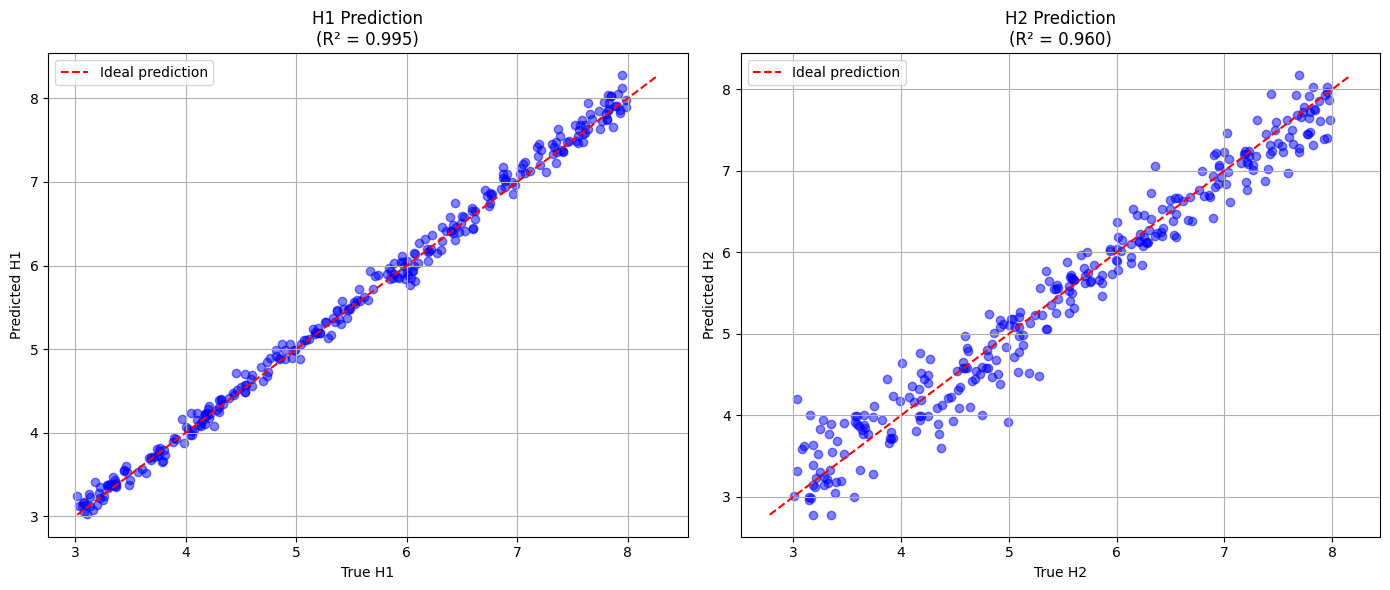

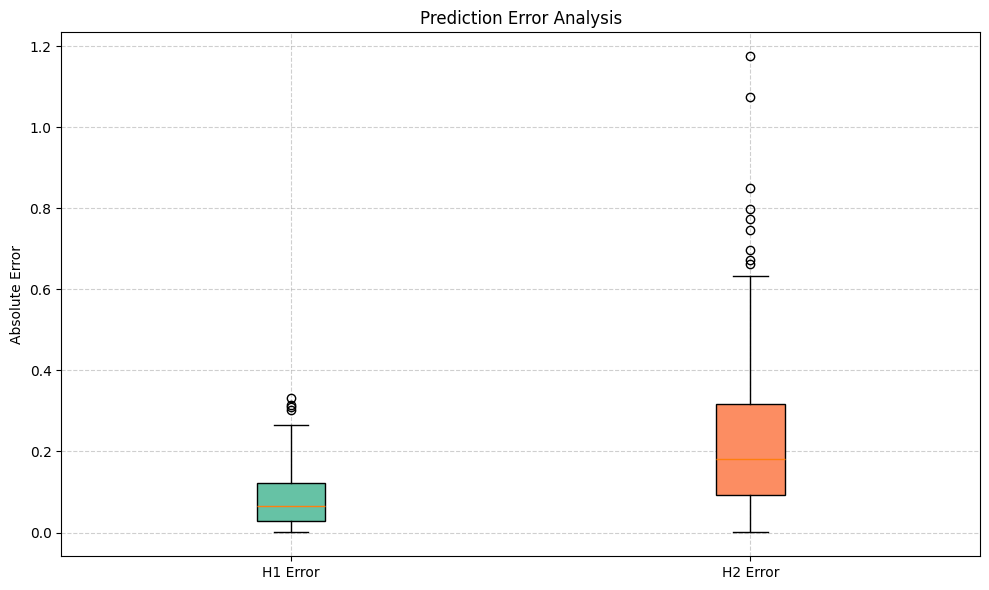

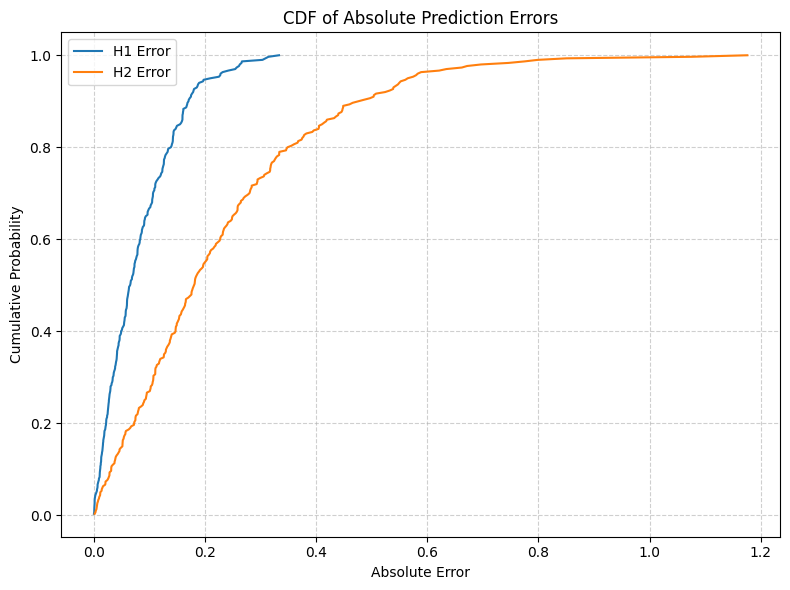

In [ ]:
# Predict and Inverse-Transform y
# -------------------------------
Y_pred = y_pred_all.copy()

# Use the correct Y_test from THIS split as the true values for evaluation
Y_true = y_true_all.copy() # Now Y_true and Y_pred will have the same number of samples (219)

# -------------------------------
# Evaluate and Plot (assuming helper functions are defined elsewhere)
# -------------------------------
results = evaluate_predictions(Y_true,Y_pred) # Y_true and Y_pred have 219 samples

print("-------------------------------------------")
comparison_df = create_comparison_df(Y_true, Y_pred) # Use Y_true for consistency
print(comparison_df)

print("-------------------------------------------")

# Customized plot
fig = plot_predictions(Y_true, Y_pred, # Use Y_true
                      target_names=['H1', 'H2'],
                      figsize=(14, 6),
                      alpha=0.5,
                      color='blue')

# Basic boxplot
fig, stats = plot_error_analysis(Y_pred, Y_true) # Use Y_true

# Ensure Y_test is also a numpy array for plot_error_cdfs
fig = plot_error_cdfs(Y_true, Y_pred, target_names=['H1', 'H2']) # Use Y_true




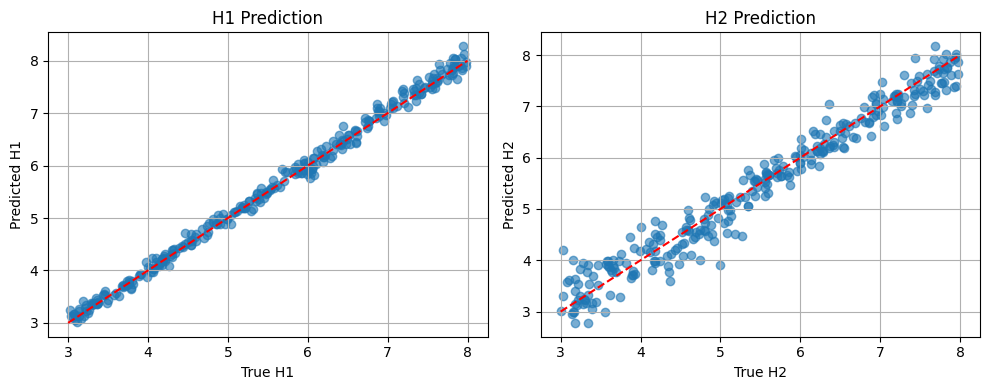

In [ ]:
# H1 Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_true_all[:, 0],y_pred_all[:, 0], alpha=0.6)
plt.plot([3, 8], [3, 8], 'r--')
plt.xlabel("True H1")
plt.ylabel("Predicted H1")
plt.title("H1 Prediction")
plt.grid(True)

# H2 Plot
plt.subplot(1, 2, 2)
plt.scatter(y_true_all[:, 1],y_pred_all[:, 1], alpha=0.6)
plt.plot([3, 8], [3, 8], 'r--')
plt.xlabel("True H2")
plt.ylabel("Predicted H2")
plt.title("H2 Prediction")
plt.grid(True)

plt.tight_layout()
plt.show()

#HYPERPRAMETER TUNING

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the model
mlp_model = MLPRegressor(max_iter=1000, random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  # Different layer sizes
    'activation': ['relu', 'tanh'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Optimizers
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Learning rate strategies
    'learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rate
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization term
    'batch_size': [32, 64, 128],  # Batch sizes
    'early_stopping': [True, False],  # Early stopping to prevent overfitting
}

# Randomized search with cross-validation
random_search = RandomizedSearchCV(mlp_model, param_distributions=param_grid, n_iter=50, cv=5, verbose=2, random_state=42)

# Assuming X_train and y_train are your input features (Δf1, Δf2, ΔPtie, disturbances) and target variables (H1, H2)
random_search.fit(X_train_scaled, Y_train_scaled)

# Print best hyperparameters and performance
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END activation=tanh, alpha=0.01, batch_size=64, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=invscaling, learning_rate_init=0.01, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.01, batch_size=64, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=invscaling, learning_rate_init=0.01, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.01, batch_size=64, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=invscaling, learning_rate_init=0.01, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.01, batch_size=64, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=invscaling, learning_rate_init=0.01, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.01, batch_size=64, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=invscaling, learning_rate_init=0.01, solver=sgd; total time=   0.1s
[CV] END activation=tanh, al

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=128, early_stopping=True, hidden_layer_sizes=(50, 50), learning_rate=invscaling, learning_rate_init=0.001, solver=sgd; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=128, early_stopping=True, hidden_layer_sizes=(50, 50), learning_rate=invscaling, learning_rate_init=0.001, solver=sgd; total time=   7.2s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=128, early_stopping=True, hidden_layer_sizes=(50, 50), learning_rate=invscaling, learning_rate_init=0.001, solver=sgd; total time=   6.6s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=128, early_stopping=True, hidden_layer_sizes=(50, 50), learning_rate=invscaling, learning_rate_init=0.001, solver=sgd; total time=   8.7s
[CV] END activation=tanh, alpha=0.001, batch_size=32, early_stopping=False, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, batch_size=32, early_stopping=False, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.001, batch_size=32, early_stopping=False, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.001, batch_size=32, early_stopping=False, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, batch_size=32, early_stopping=False, hidden_la

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=64, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   3.9s
[CV] END activation=tanh, alpha=0.01, batch_size=64, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=64, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   5.2s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, batch_size=64, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   4.0s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, early_stopping=False, hidden_layer_sizes=(100, 100), learning_rate=invscaling, learning_rate_init=0.001, solver=adam; total time=   2.7s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, early_stopping=False, hidden_layer_sizes=(100, 100), learning_rate=invscaling, learning_rate_init=0.001, solver=adam; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, early_stopping=False, hidden_layer_sizes=(100, 100), learning_rate=invscaling, learning_rate_init=0.001, solver=adam; total time=   4.6s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, early_stopping=False, hidden_layer_sizes=(100, 100), learning_rate=invscaling, learning_rate_init=0.001, solver=adam; total time=   1.9s
[CV] END activation=tanh, alpha=0.0001, batch_size=

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=128, early_stopping=True, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=128, early_stopping=True, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=128, early_stopping=True, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=128, early_stopping=True, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, batch_size=128, early_stopping=True, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   4.4s
[CV] END activation=tanh, alpha=0.01, batch_size=32, early_stopping=False, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.0s
[CV] END activation=tanh, alpha=0.01, batch_size=32, early_stopping=False, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.1s
[CV] END activation=tanh, alpha=0.01, batch_size=32, early_stopping=False, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, batch_size=32, early_stopping=False, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, batch_size=32, early_stopping=False, 

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   4.0s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, early_stopping=False, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.5s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, early_stopping=False, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, early_stopping=False, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, early_stopping=False, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   0.8s
[CV] END activation=tanh, alpha=0.0001, batch_size=64, early_stoppin

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, early_stopping=True, hidden_layer_sizes=(100, 100), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  12.8s
[CV] END activation=relu, alpha=0.0001, batch_size=64, early_stopping=True, hidden_layer_sizes=(100, 100), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  11.7s
[CV] END activation=relu, alpha=0.0001, batch_size=64, early_stopping=True, hidden_layer_sizes=(100, 100), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=   6.9s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, early_stopping=True, hidden_layer_sizes=(100, 100), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  12.6s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, batch_size=64, early_stopping=True, hidden_layer_sizes=(100, 100), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  12.5s
[CV] END activation=tanh, alpha=0.001, batch_size=32, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=invscaling, learning_rate_init=0.001, solver=sgd; total time=   2.2s
[CV] END activation=tanh, alpha=0.001, batch_size=32, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=invscaling, learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, batch_size=32, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=invscaling, learning_rate_init=0.001, solver=sgd; total time=   2.6s
[CV] END activation=tanh, alpha=0.001, batch_size=32, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=invscaling, learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, batch_size=32, early_stopping=True, h

In [ ]:
# Use the best model to predict on the test set
best_model = random_search.best_estimator_

# Assuming X_test and y_test are your test features (Δf1, Δf2, ΔPtie, disturbances) and target variables (H1, H2)
y_pred_scaled = best_model.predict(X_test_scaled)

# Calculate performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For H1

y_pred = scaler.inverse_transform(y_pred_scaled)
y_test = scaler.inverse_transform(Y_test_scaled)

# rmse_h1 = np.sqrt(mean_squared_error(y_test[:, 0], y_pred[:, 0]))
# mae_h1 = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
# r2_h1 = r2_score(y_test[:, 0], y_pred[:, 0])

# # For H2
# rmse_h2 = np.sqrt(mean_squared_error(y_test[:, 1], y_pred[:, 1]))
# mae_h2 = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
# r2_h2 = r2_score(y_test[:, 1], y_pred[:, 1])

# print(f"Test RMSE for H1: {rmse_h1:.4f}")
# print(f"Test MAE for H1: {mae_h1:.4f}")
# print(f"Test R² for H1: {r2_h1:.4f}")

# print(f"Test RMSE for H2: {rmse_h2:.4f}")
# print(f"Test MAE for H2: {mae_h2:.4f}")
# print(f"Test R² for H2: {r2_h2:.4f}")


Test RMSE for H1: 0.2240
Test MAE for H1: 0.1717
Test R² for H1: 0.9688
Test RMSE for H2: 0.2753
Test MAE for H2: 0.2010
Test R² for H2: 0.9446


H1 → R²: 0.96884, RMSE: 0.22400, MAE: 0.17171, MAPE: 3.09%
H2 → R²: 0.94458, RMSE: 0.27528, MAE: 0.20101, MAPE: 3.38%
-------------------------------------------
     H1_actual   H1_pred  H2_actual   H2_pred
0     5.777545  6.075096   6.080493  5.999364
1     7.933983  7.873391   5.339190  5.363025
2     4.452408  4.302664   3.978493  4.084326
3     5.661653  5.911738   4.485403  4.645722
4     5.666003  5.460754   4.502955  4.505621
..         ...       ...        ...       ...
212   4.711536  4.572633   4.462227  4.618218
213   5.735141  5.767226   7.960858  7.839750
214   7.131289  7.155549   4.550109  4.446082
215   5.727813  5.741267   7.622150  6.940781
216   6.393566  6.483556   6.584186  6.846011

[217 rows x 4 columns]
-------------------------------------------
📊 Error Statistics:

H1:
  Mean Absolute Error: 0.1717
  Median Absolute Error: 0.1374
  Max Error: 0.8494
  Standard Deviation: 0.1438

H2:
  Mean Absolute Error: 0.2010
  Median Absolute Error: 0.1444
  Max Error: 1.

<ipython-input-286-2910689032>:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([errors[:, i] for i in range(len(target_names))],


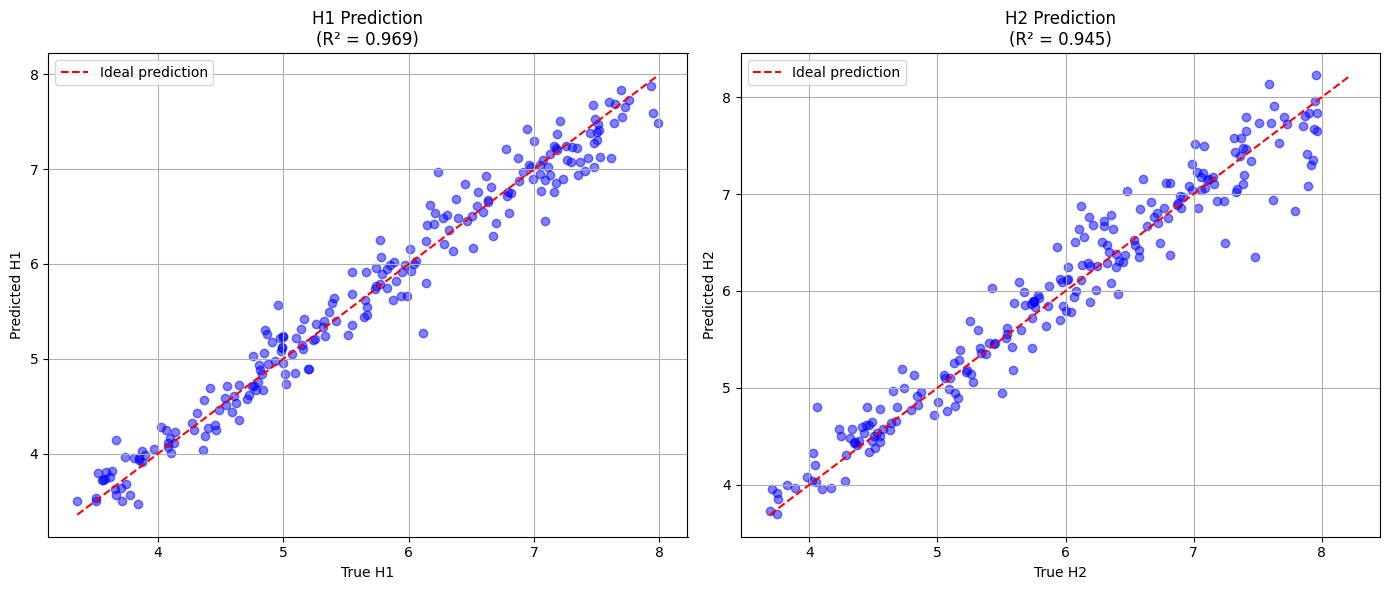

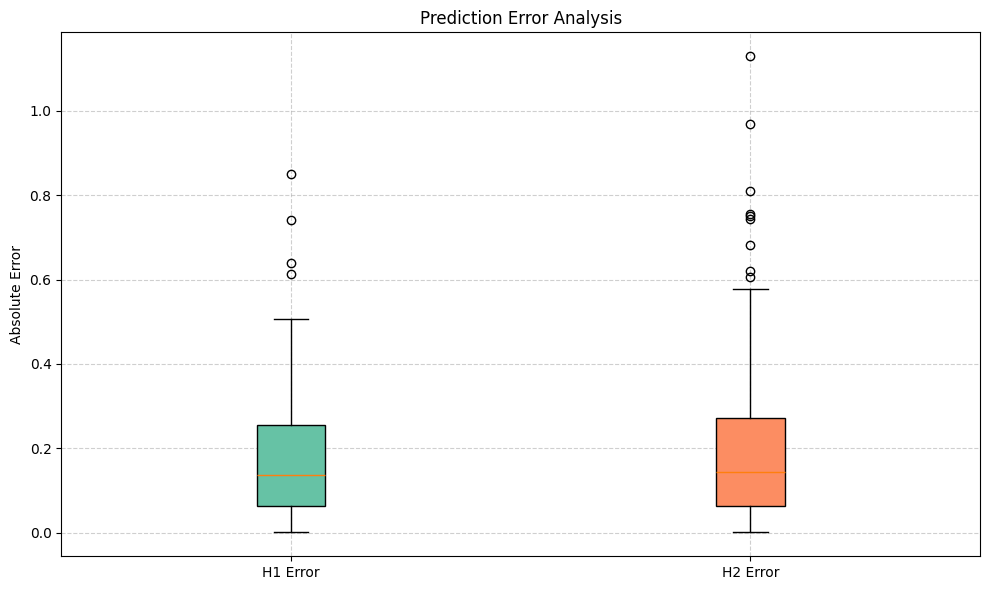

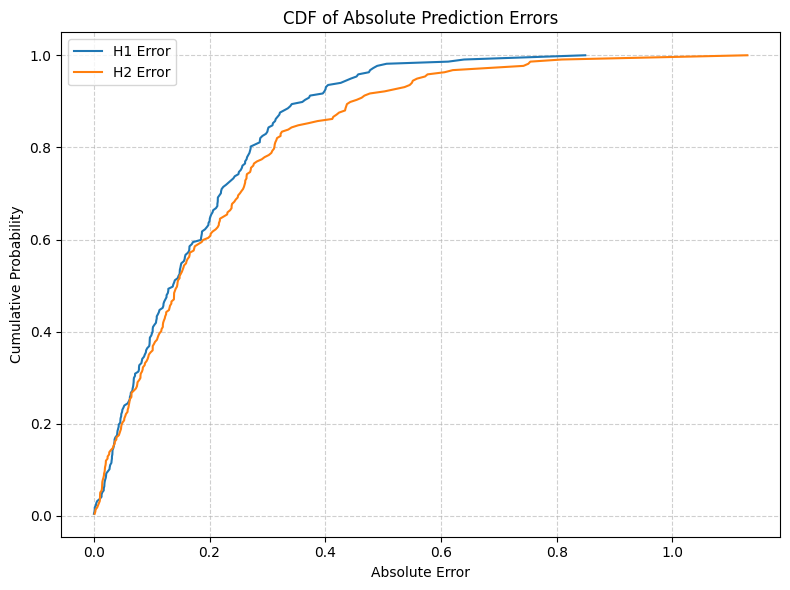

In [ ]:
# Predict and Inverse-Transform y
# -------------------------------
Y_pred = y_pred.copy()

# Use the correct Y_test from THIS split as the true values for evaluation
Y_true = y_test.copy() # Now Y_true and Y_pred will have the same number of samples (219)

# -------------------------------
# Evaluate and Plot (assuming helper functions are defined elsewhere)
# -------------------------------
results = evaluate_predictions(Y_true,Y_pred) # Y_true and Y_pred have 219 samples

print("-------------------------------------------")
comparison_df = create_comparison_df(Y_true, Y_pred) # Use Y_true for consistency
print(comparison_df)

print("-------------------------------------------")

# Customized plot
fig = plot_predictions(Y_true, Y_pred, # Use Y_true
                      target_names=['H1', 'H2'],
                      figsize=(14, 6),
                      alpha=0.5,
                      color='blue')

# Basic boxplot
fig, stats = plot_error_analysis(Y_pred, Y_true) # Use Y_true

# Ensure Y_test is also a numpy array for plot_error_cdfs
fig = plot_error_cdfs(Y_true, Y_pred, target_names=['H1', 'H2']) # Use Y_true




#MLP with 1 layer

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
#df = pd.read_csv("simulink_feature_dataset_1000_swear.csv")



In [ ]:
#Split into features and targets
X = df.iloc[:, :-2].values  # first 18 columns
y = df.iloc[:, -2:].values  # last 2 columns: [H1, H2]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Feature scaler
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# Target scaler (important!)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)



In [ ]:
print("X dimensions: ",X.shape)
print("Y dimensions: ",y.shape)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class InertiaRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = InertiaRegressionDataset(X_train_scaled, y_train_scaled)
test_dataset = InertiaRegressionDataset(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)




In [ ]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64
            ),
            nn.ReLU(),
            nn.Linear(64, 2),
            #nn.ReLU(),
            #nn.Linear(128, 2)  # 2 outputs: H1 and H2
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel(input_dim=21)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)




for epoch in range(1000):
    model.train()
    running_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100

model.eval()
y_pred_all, y_true_all = [], []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        output = model(batch_x).cpu().numpy()
        y_pred_all.append(output)
        y_true_all.append(batch_y.numpy())

y_pred_all = np.concatenate(y_pred_all, axis=0)
y_true_all = np.concatenate(y_true_all, axis=0)


# After collecting predictions and targets
y_pred_all = y_scaler.inverse_transform(y_pred_all)
y_true_all = y_scaler.inverse_transform(y_true_all)




In [ ]:
# Metrics
mse = np.mean((y_true_all - y_pred_all)**2)
mae = mean_absolute_error(y_true_all, y_pred_all)
mape = mean_absolute_percentage_error(y_true_all, y_pred_all)
r2 = r2_score(y_true_all, y_pred_all)

print(f"Test MSE:  {mse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test R^2:  {r2:.4f}")

In [ ]:
# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error


for i, name in enumerate(['H1', 'H2']):
    true = y_true_all[:, i]
    pred = y_pred_all[:, i]
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape_val = mean_absolute_percentage_error(true, pred)*100
    print(f"{name} → R²: {r2:.5f}, RMSE: {rmse:.5f},MAE: {mae:.5f}, MAPE: {mape_val:.2f}%")


In [ ]:
import matplotlib.pyplot as plt
# H1 Plot

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_true_all[:, 0],y_pred_all[:, 0], alpha=0.6)
plt.plot([3, 8], [3, 8], 'r--')
plt.xlabel("True H1")
plt.ylabel("Predicted H1")
plt.title("H1 Prediction")
plt.grid(True)

# H2 Plot
plt.subplot(1, 2, 2)
plt.scatter(y_true_all[:, 1],y_pred_all[:, 1], alpha=0.6)
plt.plot([3, 8], [3, 8], 'r--')
plt.xlabel("True H2")
plt.ylabel("Predicted H2")
plt.title("H2 Prediction")
plt.grid(True)

plt.tight_layout()
plt.show()

Checking some staff

In [ ]:
from sklearn.model_selection import train_test_split

# Load your dataset
import pandas as pd
df = pd.read_csv('simulink_feature_dataset_1000_new_outliers.csv')

X = df.drop(columns=['H1', 'H2'])
y = df[['H1', 'H2']]

# Check train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check sizes
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


In [ ]:
# Correlation matrix including targets
corr_matrix = df.corr()

# Show correlations with H1 and H2
print("Correlation with H1:\n", corr_matrix['H1'].sort_values(ascending=False))
print("Correlation with H2:\n", corr_matrix['H2'].sort_values(ascending=False))


In [ ]:
# Compute absolute correlation matrix
corr_matrix = df.corr().abs()

# Select only correlations of features with H1 and H2
feature_corr = corr_matrix[['H1', 'H2']].drop(index=['H1', 'H2'])
print("🔍 Correlation of features with targets:\n")
print(feature_corr)

# Set a minimum correlation threshold
threshold = 0.2

# Keep only features where correlation with at least one target is above threshold
selected_features = feature_corr[(feature_corr['H1'] > threshold) | (feature_corr['H2'] > threshold)].index.tolist()
print("\n✅ Selected features (correlation > 0.2):", selected_features)

# Create new filtered dataset with selected features + targets
df_filtered = df[selected_features + ['H1', 'H2']]

In [ ]:
from sklearn.utils import shuffle

y_shuffled = shuffle(y, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_shuffled.loc[X_train.index])
score = model.score(X_test, y_shuffled.loc[X_test.index])

print(f"Sanity check R^2 with shuffled targets: {score:.4f}")


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

model = RandomForestRegressor()

# Example for H1 only
scores = cross_val_score(model, X, y['H1'], cv=5, scoring='r2')
print(f"Cross-validated R^2 for H1: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


In [ ]:
print(df.columns)


In [ ]:
corr_matrix = df.corr()
print(corr_matrix[['H1', 'H2']].sort_values(by='H1', ascending=False))


#Inertia Estimation Using derivatives of Δf1,Δf2.

In [ ]:
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error # Import mean_squared_error
import numpy as np

# Define mean_absolute_percentage_error function if it's not already defined elsewhere
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100


# === Load Dataset ===
# Ensure data and targets are loaded *inside* the with block
with h5py.File('simulink_derivatives_1000.mat', 'r') as f:
    data = np.array(f['all_derivatives'])       # shape: (N, T, 3)
    targets = np.array(f['all_targets']) # shape: (N, 2)

# Now 'data' and 'targets' are loaded and available outside the with block
print("Data shape:", data.shape)
print("Targets shape:", targets.shape)

In [ ]:
# Convert and transpose
X_old = torch.tensor(np.transpose(data, (2, 1, 0)), dtype=torch.float32)  # (N, 6001, 3)
Y_old = torch.tensor(targets.T, dtype=torch.float32)                      # (N, 2)

print(X_old.shape)
print(Y_old.shape)

In [ ]:
import matplotlib.pyplot as plt

def plot_derivative(idx, X, Y, title_suffix=""):
    derΔf1 = X[idx, :, 0].numpy()
    derΔf2 = X[idx, :, 1].numpy()
    derΔPtie = X[idx, :, 2].numpy()
    H1, H2 = Y[idx, 0].item(), Y[idx, 1].item()

    plt.figure(figsize=(14, 4))
    plt.plot(derΔf1, label="dΔf1/dt")
    plt.plot(derΔf2, label="dΔf2/dt")
    plt.plot(derΔPtie, label="dΔPtie/dt")
    plt.title(f"Sample #{idx} — H1: {H1:.2f}, H2: {H2:.2f} {title_suffix}")
    plt.xlabel("Time Step (0.01s)")
    plt.ylabel("Signal Value")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
plot_derivative(idx=152, X=X_old, Y=Y_old, title_suffix=" (Raw, unnormalized)")

We do not need the derivative of ΔPtie so we delete it form the tensor

In [ ]:
X_old = np.delete(X_old, 2, axis=2)
print("X_old shape: ",X_old.shape)

In [ ]:
data = X_old
targets = Y_old

In [ ]:
# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=42)

# === PyTorch Dataset ===
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 2, 1)  # (N, C=3, T)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SequenceDataset(X_train, y_train)
test_ds = SequenceDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# === CNN Model ===
class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # output shape (N, 64, 1)
        )
        self.fc = nn.Linear(64, 2)  # H1 and H2

    def forward(self, x):
        x = self.cnn(x)
        x = x.squeeze(-1)  # remove last dim
        return self.fc(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNRegressor().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# === Training Loop ===
for epoch in range(50):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

# === Evaluation ===
model.eval()
y_preds, y_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()
        y_preds.append(preds)
        y_true.append(y_batch.numpy())

y_preds = np.concatenate(y_preds, axis=0)
y_true = np.concatenate(y_true, axis=0)

print(f"Test R^2: {r2_score(y_true, y_preds)}")
print(f"Test MAE: {mean_absolute_error(y_true, y_preds)}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_true, y_preds))}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_true, y_preds)}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# === LSTM Model ===
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Linear(hidden_size, 2)  # Predict H1 and H2

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, seq_len, hidden_size)
        # Take the last time step's output
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out)

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=42)

# === PyTorch Dataset ===
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        # No permute needed - LSTM expects (N, T, C)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SequenceDataset(X_train, y_train)
test_ds = SequenceDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# === Training Setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMRegressor().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# === Training Loop ===
for epoch in range(50):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

# === Evaluation ===
model.eval()
y_preds, y_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()
        y_preds.append(preds)
        y_true.append(y_batch.numpy())

y_preds = np.concatenate(y_preds, axis=0)
y_true = np.concatenate(y_true, axis=0)

print(f"Test R^2: {r2_score(y_true, y_preds)}")
print(f"Test MAE: {mean_absolute_error(y_true, y_preds)}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_true, y_preds))}")

Feature engineeering from the derivatives

In [ ]:
import h5py
import torch
import numpy as np
import pandas as pd

# === Load the .mat file ===
with h5py.File('simulink_derivatives_1000.mat', 'r') as f:
    all_data = f['all_derivatives'][:]        # shape: (3, 6001, N)
    all_targets = f['all_targets'][:]  # shape: (2, N)

# === Convert and transpose ===
# Changed 'all_derivatives' to 'all_data' to match the loaded variable name
X = torch.tensor(np.transpose(all_data, (2, 1, 0)), dtype=torch.float32)  # (N, 6001, 3)
Y = torch.tensor(all_targets.T, dtype=torch.float32)                      # (N, 2)

X  = np.delete(X, 2, axis=2)

# === Feature Extraction Function ===
def extract_features(signal):
    return {
        'mean': signal.mean().item(),
        'd':    signal.std().item(),
        'max': signal.max().item(),
        'min': signal.min().item(),
        'ptp': (signal.max() - signal.min()).item(),
        'rms': torch.sqrt(torch.mean(signal**2)).item()
    }



# === Extract features for each sample ===
rows = []
for i in range(X.shape[0]):
    feats = {}
    # The loop iterates over 3 channels, but X now only has 2 channels after np.delete.
    # This might cause an IndexError later if j goes up to 2.
    # Consider adjusting the loop or the deletion based on intended logic.
    # For now, keeping the original loop structure, assuming the deletion of the 3rd channel (index 2)
    # is correct, and the loop should probably only iterate over the remaining channels.
    # Assuming the intention is to loop through the channels present in the modified X:
    for j in range(X.shape[2]): # Loop through the actual number of channels in X
        # Need to determine the appropriate names for the remaining channels.
        # If the original channels were ['f1', 'f2', 'ptie'] and 'ptie' (index 2) was deleted,
        # the remaining names would be ['f1', 'f2'].
        # Let's assume the names should correspond to the remaining channels:
        names = ['df1/dt', 'df2/dt'] # Update names based on the deleted column
        name = names[j]

        sig = X[i, :, j]
        sig_feats = extract_features(sig)
        for stat, val in sig_feats.items():
            feats[f"{name}_{stat}"] = val

    feats['H1'] = Y[i, 0].item()
    feats['H2'] = Y[i, 1].item()
    rows.append(feats)

# === Create DataFrame and Save ===
df = pd.DataFrame(rows)
df.to_csv("simulink_derivatives_1000.csv", index=False)
print("✅ Saved CSV with feature names to 'simulink_derivatives_1000.csv'")

In [ ]:
import pandas as pd

Statistic_Data = pd.read_csv('simulink_derivatives_1000.csv')

Statistic_Data.head()

In [ ]:
df = Statistic_Data.copy()

print(df.shape)

CHECK FOR INSTABILITY (PP)

In [ ]:
# Compute absolute correlation matrix
corr_matrix = df.corr().abs()

# Select only correlations of features with H1 and H2
feature_corr = corr_matrix[['H1', 'H2']].drop(index=['H1', 'H2'])
print("🔍 Correlation of features with targets:\n")
print(feature_corr)

# Set a minimum correlation threshold
threshold = 0.2

# Keep only features where correlation with at least one target is above threshold
selected_features = feature_corr[(feature_corr['H1'] > threshold) | (feature_corr['H2'] > threshold)].index.tolist()
print("\n✅ Selected features (correlation > 0.2):", selected_features)

# Create new filtered dataset with selected features + targets
df_filtered = df[selected_features + ['H1', 'H2']]

In [ ]:
X = df_filtered.iloc[:, :-2].values
Y = df_filtered.iloc[:, -2:].values

print(X.shape)
print(Y.shape)

In [ ]:

from sklearn.model_selection import train_test_split


# === Train/test split ===
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Y_train_scaled = scaler.fit_transform(Y_train)
Y_test_scaled = scaler.transform(Y_test)

#RANDOM FOREST

In [ ]:
# === Train random forest ===

from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, Y_train_scaled)

# === Predict and evaluate ===
Y_pred_scaled = rf.predict(X_test_scaled)

In [ ]:

Y_pred = scaler.inverse_transform(Y_pred_scaled)
Y_true = scaler.inverse_transform(Y_test_scaled)


In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error


# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

for i, name in enumerate(['H1', 'H2']):
    true = Y_true[:, i]
    pred = Y_pred[:, i]
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape_val = mean_absolute_percentage_error(true, pred)*100
    print(f"{name} → R²: {r2:.5f}, RMSE: {rmse:.5f},MAE: {mae:.5f}, MAPE: {mape_val:.2f}%")


In [ ]:
# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({
    'H1_actual': Y_test[:,0],
    'H1_pred': Y_pred[:,0],
    'H2_actual': Y_test[:,1],
    'H2_pred': Y_pred[:,1]

})

# Print the DataFrame
print(comparison_df)

In [ ]:
import matplotlib.pyplot as plt

# H1 Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(Y_test[:, 0],Y_pred[:, 0], alpha=0.6)
plt.plot([3, 8], [3, 8], 'r--')
plt.xlabel("True H1")
plt.ylabel("Predicted H1")
plt.title("H1 Prediction")
plt.grid(True)

# H2 Plot
plt.subplot(1, 2, 2)
plt.scatter(Y_test[:, 1],Y_pred[:, 1], alpha=0.6)
plt.plot([3, 8], [3, 8], 'r--')
plt.xlabel("True H2")
plt.ylabel("Predicted H2")
plt.title("H2 Prediction")
plt.grid(True)

plt.tight_layout()
plt.show()

#XGBOOST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
import xgboost as xgb

# === Load dataset ===
#df = pd.read_csv("simulink_feature_dataset_1000_swear.csv")
#df is created for the previous model

print("df shape: ",df.shape)

In [ ]:


# === Separate features and targets ===
X = df.drop(columns=['H1', 'H2']).values
Y = df[['H1', 'H2']].values

# === Train/val/test split ===
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# === Min-Max Scaling ===
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled   = X_scaler.transform(X_val)
X_test_scaled  = X_scaler.transform(X_test)

Y_train_scaled = Y_scaler.fit_transform(Y_train)
Y_val_scaled   = Y_scaler.transform(Y_val)
Y_test_scaled  = Y_scaler.transform(Y_test)

# === Train a separate XGBoost model for H1 and H2 ===
models = []
for i in range(Y.shape[1]):
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train_scaled, Y_train_scaled[:, i])
    models.append(model)

# === Predict and inverse transform ===
Y_pred_scaled = np.column_stack([model.predict(X_test_scaled) for model in models])
Y_pred = Y_scaler.inverse_transform(Y_pred_scaled)
Y_true = Y_scaler.inverse_transform(Y_test_scaled)





In [ ]:
for i, name in enumerate(['H1', 'H2']):
    true = Y_test[:, i]
    pred = Y_pred[:, i]
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape_val = mean_absolute_percentage_error(true, pred)*100
    print(f"{name} → R²: {r2:.5f}, RMSE: {rmse:.5f},MAE: {mae:.5f}, MAPE: {mape_val:.2f}%")

In [ ]:
# H1 Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(Y_test[:, 0],Y_pred[:, 0], alpha=0.6)
plt.plot([3, 8], [3, 8], 'r--')
plt.xlabel("True H1")
plt.ylabel("Predicted H1")
plt.title("H1 Prediction")
plt.grid(True)

# H2 Plot
plt.subplot(1, 2, 2)
plt.scatter(Y_test[:, 1],Y_pred[:, 1], alpha=0.6)
plt.plot([3, 8], [3, 8], 'r--')
plt.xlabel("True H2")
plt.ylabel("Predicted H2")
plt.title("H2 Prediction")
plt.grid(True)

plt.tight_layout()
plt.show()

#MLP 2 Layers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# # Load data
# df = pd.read_csv("simulink_feature_dataset_1000_swear.csv")
print (df.shape)


In [ ]:
# Compute absolute correlation matrix
corr_matrix = df.corr().abs()

# Select only correlations of features with H1 and H2
feature_corr = corr_matrix[['H1', 'H2']].drop(index=['H1', 'H2'])
print("🔍 Correlation of features with targets:\n")
print(feature_corr)

# Set a minimum correlation threshold
threshold = 0.2

# Keep only features where correlation with at least one target is above threshold
selected_features = feature_corr[(feature_corr['H1'] > threshold) | (feature_corr['H2'] > threshold)].index.tolist()
print("\n✅ Selected features (correlation > 0.2):", selected_features)

# Create new filtered dataset with selected features + targets
df_filtered = df[selected_features + ['H1', 'H2']]

In [ ]:
#Split into features and targets
X = df.iloc[:, :-2].values  # first 18 columns
y = df.iloc[:, -2:].values  # last 2 columns: [H1, H2]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
from sklearn.preprocessing import StandardScaler

# Feature scaler
x_scaler =MinMaxScaler()
y_scaler = MinMaxScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# Target scaler (important!)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class InertiaRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = InertiaRegressionDataset(X_train_scaled, y_train_scaled)
test_dataset = InertiaRegressionDataset(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)




In [ ]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64
            ),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 2 outputs: H1 and H2
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel(input_dim=12)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)




for epoch in range(1000):
    model.train()
    running_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100

model.eval()
y_pred_all, y_true_all = [], []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        output = model(batch_x).cpu().numpy()
        y_pred_all.append(output)
        y_true_all.append(batch_y.numpy())

y_pred_all = np.concatenate(y_pred_all, axis=0)
y_true_all = np.concatenate(y_true_all, axis=0)


# After collecting predictions and targets
y_pred_all = y_scaler.inverse_transform(y_pred_all)
y_true_all = y_scaler.inverse_transform(y_true_all)


# Metrics
mse = np.mean((y_true_all - y_pred_all)**2)
mae = mean_absolute_error(y_true_all, y_pred_all)
mape = mean_absolute_percentage_error(y_true_all, y_pred_all)
r2 = r2_score(y_true_all, y_pred_all)

print(f"Test MSE:  {mse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test R^2:  {r2:.4f}")


In [ ]:
# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error


for i, name in enumerate(['H1', 'H2']):
    true = y_true_all[:, i]
    pred = y_pred_all[:, i]
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape_val = mean_absolute_percentage_error(true, pred)*100
    print(f"{name} → R²: {r2:.5f}, RMSE: {rmse:.5f},MAE: {mae:.5f}, MAPE: {mape_val:.2f}%")


In [ ]:
# H1 Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_true_all[:, 0],y_pred_all[:, 0], alpha=0.6)
plt.plot([3, 8], [3, 8], 'r--')
plt.xlabel("True H1")
plt.ylabel("Predicted H1")
plt.title("H1 Prediction")
plt.grid(True)

# H2 Plot
plt.subplot(1, 2, 2)
plt.scatter(y_true_all[:, 1],y_pred_all[:, 1], alpha=0.6)
plt.plot([3, 8], [3, 8], 'r--')
plt.xlabel("True H2")
plt.ylabel("Predicted H2")
plt.title("H2 Prediction")
plt.grid(True)

plt.tight_layout()
plt.show()

£CNN with raw data

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    # Input shape: (time_steps, 3) for stacked time-series
    layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(1000, 3)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    # Two outputs for H1 and H2
    layers.Dense(2)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Load .mat data
import scipy.io
data = scipy.io.loadmat('data.mat')
X = data['X']  # Shape: (n_samples, 1000, 3)
y = data['y']  # Shape: (n_samples, 2)

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Train model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.15)

# Evaluate
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")